# AP-1 FDR Analysis

## Imports

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import matplotlib_venn
import sklearn.decomposition
import scipy.stats
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('talk')

In [2]:
workingDirectory = '/home/jtao/analysis/ap1_fdr_analysis/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)
peakDirectory = '/home/jtao/analysis/ap1_fdr_analysis/peak_files/'
tagDirPath = '/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/'

In [3]:
# file directories

os.chdir(workingDirectory)

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(tagDirPath)):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in [x for x in sorted(os.listdir(tagDirPath)) if not 'nput' in x and not 'p65' in x and not 'cebp' in x]:
    logFile = [x for x in os.listdir(tagDirPath + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(tagDirPath + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort_index()

In [4]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

Number of Samples: 32
Number of discarded samples: 0
Number of Samples remaining after filtering: 32


## Peak Calling

In [5]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile = open('./peakCalling_homer.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    if "veh" in treatment.lower():
        inputDir = '/home/jtao/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
    elif "kla" in treatment.lower():
        inputDir = '/home/jtao/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
    
    scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                 ' -i ' + inputDir
                 + ' -style factor -size 200 > ' + 
                 peakDirectory +'/' + peakFileName + ' &\n')
scriptFile.close()

In [ ]:
%%bash
rm ./peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer.sh

## Copy IDR Peak files

In [216]:
%%bash
if [ ! -d ./idr_peak_files ]; then mkdir ./idr_peak_files; else rm ./idr_peak_files/*; fi
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_files/c57bl6* ./idr_peak_files/
rm ./idr_peak_files/*p65*
rm ./idr_peak_files/*cebp*
rm ./idr_peak_files/*pu1*

for i in ./idr_peak_files/*;
    do mv $i ${i/_peaks.tsv/_idr_peaks.tsv};
done

## Peak Filtering

In [223]:
!rm ./filtered_peak_files/*

In [224]:
# filter away peaks that have less than 16 normalized tags
# rename peak files to remove redundant information
chroms = ['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX']
seen_conditions = set()
peakDirectory = './peak_files/'
filtered_peak_directory = './filtered_peak_files/'
if not os.path.isdir(filtered_peak_directory):
    os.mkdir(filtered_peak_directory)
for f in os.listdir(peakDirectory):
    tokens = f.split('_')
    condition = tokens[0] +'_'+ tokens[1] + '_' + tokens[2]
    if tokens[1] in ['atf3','cjun','jund']:
        print(f)
        if condition in seen_conditions:
            new_name = filtered_peak_directory+'/'+condition + '_rep2_peaks.tsv' 
        else:
            new_name = filtered_peak_directory+'/'+condition + '_rep1_peaks.tsv' 
            seen_conditions.add(condition)
        current_frame = pd.read_csv(peakDirectory + '/' + f, sep = '\t', skiprows=39)
        filtered_frame = current_frame[(current_frame['chr'].isin(chroms)) &
                                      (current_frame['Normalized Tag Count'] >= 16)]
        filtered_frame.to_csv(new_name, sep='\t', index=False)

c57bl6_atf3_kla_16-04-21_1_default_peaks.tsv
c57bl6_jund_kla_16-04-21_1_default_peaks.tsv
c57bl6_cjun_veh_16-04-21_1_default_peaks.tsv
c57bl6_atf3_kla_16-08-16_1_default_peaks.tsv
c57bl6_jund_veh_16-07-23_1_default_peaks.tsv
c57bl6_jund_kla_15-11-18_1_default_peaks.tsv
c57bl6_atf3_veh_16-07-23_1_default_peaks.tsv
c57bl6_cjun_veh_16-06-14_1_default_peaks.tsv
c57bl6_jund_veh_16-04-21_1_default_peaks.tsv
c57bl6_cjun_kla_16-04-21_1_default_peaks.tsv
c57bl6_atf3_veh_16-04-21_1_default_peaks.tsv
c57bl6_cjun_kla_15-11-18_1_default_peaks.tsv


In [229]:
!rm ./filtered_idr_peak_files/*

In [231]:
# filter away peaks that have less than 16 normalized tags
# rename peak files to remove redundant information
chroms = ['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX']
seen_conditions = set()
filtered_peak_directory = './filtered_idr_peak_files/'
if not os.path.isdir(filtered_peak_directory):
    os.mkdir(filtered_peak_directory)
peakDirectory = './idr_peak_files/'
for f in os.listdir(peakDirectory):
    tokens = f.split('_')
    condition = tokens[0] +'_'+ tokens[1] + '_' + tokens[2]
    if tokens[1] in ['atf3', 'cjun', 'jund']:
        print(f)
        new_name = filtered_peak_directory+'/'+condition + '_idr_peaks.tsv' 
        current_frame = pd.read_csv(peakDirectory + '/' + f, sep = '\t')
        filtered_frame = current_frame[current_frame['chr'].isin(chroms)]
        filtered_frame.to_csv(new_name, sep='\t', index=False)

c57bl6_atf3_kla_idr_peaks.tsv
c57bl6_cjun_veh_idr_peaks.tsv
c57bl6_jund_kla_idr_peaks.tsv
c57bl6_cjun_kla_idr_peaks.tsv
c57bl6_atf3_veh_idr_peaks.tsv
c57bl6_jund_veh_idr_peaks.tsv


## Merge Peaks

In [232]:
%%capture
%%bash
mergePeaks -d 100 ./filtered_idr_peak_files/*tsv ./filtered_peak_files/*tsv > merged_peaks.tsv

makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./filtered_peak_files/*tsv ./filtered_idr_peak_files/*tsv

## Annotate Peaks

In [7]:
%%bash
tag_dir_path="/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/"
annotatePeaks.pl ./merged_peaks.tsv mm10 -d $tag_dir_path/*ATF3* -d $tag_dir_path/*cJun* -d $tag_dir_path/*JunD* > annotated_peaks.tsv


	Peak file = ./merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-04-21
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23
	Tag Directories:
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_cJun_KLA-1h_GFEW_15-11-18
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_cJun_KLA-1h_GJF_16-04-21
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_cJun_Veh_GJF_16-04-21
		/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1//C57Bl6_Thiomac_ChIP_cJun_Veh_GJF_16-06-14
	Tag 

## Convert to BED Files

In [234]:
%%bash
# individual replicates
if [ ! -d ./bed_files ]; then mkdir ./bed_files/; else rm ./bed_files/*; fi

for i in ./filtered_peak_files/*tsv;
    do echo $i;
    outpath=./bed_files/${i##*/}
    outpath=${outpath/_peaks.tsv/.bed}
    echo $outpath
    pos2bed.pl $i > ./tmp
    tail -n +2 ./tmp > $outpath
done

# idr peaks
for i in ./filtered_idr_peak_files/*tsv;
    do echo $i;
    outpath=./bed_files/${i##*/}
    outpath=${outpath/_peaks.tsv/.bed}
    echo $outpath
    pos2bed.pl $i > ./tmp
    tail -n +2 ./tmp > $outpath
done
rm tmp



./filtered_peak_files/c57bl6_atf3_kla_rep1_peaks.tsv
./bed_files/c57bl6_atf3_kla_rep1.bed
./filtered_peak_files/c57bl6_atf3_kla_rep2_peaks.tsv
./bed_files/c57bl6_atf3_kla_rep2.bed
./filtered_peak_files/c57bl6_atf3_veh_rep1_peaks.tsv
./bed_files/c57bl6_atf3_veh_rep1.bed
./filtered_peak_files/c57bl6_atf3_veh_rep2_peaks.tsv
./bed_files/c57bl6_atf3_veh_rep2.bed
./filtered_peak_files/c57bl6_cjun_kla_rep1_peaks.tsv
./bed_files/c57bl6_cjun_kla_rep1.bed
./filtered_peak_files/c57bl6_cjun_kla_rep2_peaks.tsv
./bed_files/c57bl6_cjun_kla_rep2.bed
./filtered_peak_files/c57bl6_cjun_veh_rep1_peaks.tsv
./bed_files/c57bl6_cjun_veh_rep1.bed
./filtered_peak_files/c57bl6_cjun_veh_rep2_peaks.tsv
./bed_files/c57bl6_cjun_veh_rep2.bed
./filtered_peak_files/c57bl6_jund_kla_rep1_peaks.tsv
./bed_files/c57bl6_jund_kla_rep1.bed
./filtered_peak_files/c57bl6_jund_kla_rep2_peaks.tsv
./bed_files/c57bl6_jund_kla_rep2.bed
./filtered_peak_files/c57bl6_jund_veh_rep1_peaks.tsv
./bed_files/c57bl6_jund_veh_rep1.bed
./filtered


	Converted 28089 peaks total


	Converted 47448 peaks total


	Converted 31478 peaks total


	Converted 23139 peaks total


	Converted 24882 peaks total


	Converted 16407 peaks total


	Converted 11348 peaks total


	Converted 12622 peaks total


	Converted 22740 peaks total


	Converted 38568 peaks total


	Converted 20965 peaks total


	Converted 18992 peaks total


	Converted 36737 peaks total


	Converted 23153 peaks total


	Converted 17477 peaks total


	Converted 15544 peaks total


	Converted 31637 peaks total


	Converted 19647 peaks total



## Extract Sequences

In [8]:
%%bash
if [ ! -d ./fasta_files ]; then mkdir ./fasta_files/; else rm ./fasta_files/*; fi

for i in ./bed_files/*bed; 
    do echo $i;
    outpath=./fasta_files/${i##*/}
    outpath=${outpath/.bed/.fasta}
    /gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py $i mm10 $outpath
done

./bed_files/c57bl6_atf3_kla_idr.bed
reading genome mm10
./bed_files/c57bl6_atf3_kla_rep1.bed
reading genome mm10
./bed_files/c57bl6_atf3_kla_rep2.bed
reading genome mm10
./bed_files/c57bl6_atf3_veh_idr.bed
reading genome mm10
./bed_files/c57bl6_atf3_veh_rep1.bed
reading genome mm10
./bed_files/c57bl6_atf3_veh_rep2.bed
reading genome mm10
./bed_files/c57bl6_cjun_kla_idr.bed
reading genome mm10
./bed_files/c57bl6_cjun_kla_rep1.bed
reading genome mm10
./bed_files/c57bl6_cjun_kla_rep2.bed
reading genome mm10
./bed_files/c57bl6_cjun_veh_idr.bed
reading genome mm10
./bed_files/c57bl6_cjun_veh_rep1.bed
reading genome mm10
./bed_files/c57bl6_cjun_veh_rep2.bed
reading genome mm10
./bed_files/c57bl6_jund_kla_idr.bed
reading genome mm10
./bed_files/c57bl6_jund_kla_rep1.bed
reading genome mm10
./bed_files/c57bl6_jund_kla_rep2.bed
reading genome mm10
./bed_files/c57bl6_jund_veh_idr.bed
reading genome mm10
./bed_files/c57bl6_jund_veh_rep1.bed
reading genome mm10
./bed_files/c57bl6_jund_veh_rep2.bed


## Construct Background

In [12]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background/ ]; then mkdir ./background/ ; fi
for i in ./bed_files/*bed;
do 
    factor=${i##*/};
    factor=${factor%.bed};
    fasta_path="./background/${factor}_background.fasta"
    bed_path="./background/${factor}_background.bed"
    if [ ! -f $fasta_path ];
    then
    echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome mm10";
    echo "mv ./background/background.bed $bed_path";
    echo "mv ./background/background.fasta $fasta_path";
    echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome mm10" >> $script_path;
    echo "mv ./background/background.bed $bed_path" >> $script_path;
    echo "mv ./background/background.fasta $fasta_path" >> $script_path;
    fi
done

/home/jtao/code/tba/generate_background_coordinates.py ./bed_files/c57bl6_atf3_kla_idr.bed ./background/ -genome mm10
mv ./background/background.bed ./background/c57bl6_atf3_kla_idr_background.bed
mv ./background/background.fasta ./background/c57bl6_atf3_kla_idr_background.fasta
/home/jtao/code/tba/generate_background_coordinates.py ./bed_files/c57bl6_atf3_kla_rep1.bed ./background/ -genome mm10
mv ./background/background.bed ./background/c57bl6_atf3_kla_rep1_background.bed
mv ./background/background.fasta ./background/c57bl6_atf3_kla_rep1_background.fasta
/home/jtao/code/tba/generate_background_coordinates.py ./bed_files/c57bl6_atf3_kla_rep2.bed ./background/ -genome mm10
mv ./background/background.bed ./background/c57bl6_atf3_kla_rep2_background.bed
mv ./background/background.fasta ./background/c57bl6_atf3_kla_rep2_background.fasta
/home/jtao/code/tba/generate_background_coordinates.py ./bed_files/c57bl6_atf3_veh_idr.bed ./background/ -genome mm10
mv ./background/background.bed ./bac

rm: cannot remove ‘./make_background.sh’: No such file or directory


In [13]:
%%bash
rm ./background/*
chmod a+x ./*sh
bash ./make_background.sh

reading genome mm10
done reading genome
0 0
target GC: 0.36373558897824004 background GC: 0.3638749580142967 target length: 234 numTargetPositions 3674 backgroundPositions 3674
0 0
target GC: 0.4051148081625316 background GC: 0.40473714080538287 target length: 234 numTargetPositions 3674 backgroundPositions 3674
0 0
target GC: 0.4275552231990519 background GC: 0.4251392765725309 target length: 234 numTargetPositions 3674 backgroundPositions 3674
0 0
target GC: 0.44549469748868537 background GC: 0.44374384692891466 target length: 234 numTargetPositions 3674 backgroundPositions 3674
0 0
target GC: 0.46144416466519017 background GC: 0.45851353386065874 target length: 234 numTargetPositions 3674 backgroundPositions 3674
0 0
target GC: 0.47776361954296315 background GC: 0.4746661416045501 target length: 234 numTargetPositions 3674 backgroundPositions 3674
0 0
target GC: 0.49498230789476183 background GC: 0.49068555345782433 target length: 234 numTargetPositions 3674 backgroundPositions 3674

rm: cannot remove ‘./background/*’: No such file or directory


## Create Features

In [16]:
%%bash
positive_seq_dir="./fasta_files/"
negative_seq_dir="./background/"
out_dir="./tba_output/"
script_path='./calculate_features.sh'
motif_dir='./jaspar_2016_curated_homerFormat/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%.fasta};

    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/*motif -num_proc 28" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/combined_features.tsv $out_dir/${factor}_combined_features.tsv" >> $script_path
done

In [ ]:
%%bash
rm ./tba_output/*motif_scores*
rm ./tba_output/*motif_starts*
chmod a+x ./*sh
bash ./calculate_features.sh

## Train Models

In [19]:
%%bash
feature_dir="./tba_output/"
out_dir="./tba_output/"
script_path='./train_classifier.sh'
iterations="1"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*combined_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/combined_features/labels};
    label_path=${label_path/tsv/txt};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

In [20]:
%%bash
rm ./tba_output/*coefficients*
rm ./tba_output/*performance*
chmod a+x ./*sh
bash ./train_classifier.sh

reading features and labels
training classifier for ./tba_output//c57bl6_atf3_kla_idr_combined_features.tsv
training iteration: 1
iteration training time: 97.16307139396667 ROC 0.930147320295
Total time: 97.16321921348572
writing results
reading features and labels
training classifier for ./tba_output//c57bl6_atf3_kla_rep1_combined_features.tsv
training iteration: 1
iteration training time: 71.75899147987366 ROC 0.937559890202
Total time: 71.75924944877625
writing results
reading features and labels
training classifier for ./tba_output//c57bl6_atf3_kla_rep2_combined_features.tsv
training iteration: 1
iteration training time: 107.45630359649658 ROC 0.927538143973
Total time: 107.45647644996643
writing results
reading features and labels
training classifier for ./tba_output//c57bl6_atf3_veh_idr_combined_features.tsv
training iteration: 1
iteration training time: 54.38340902328491 ROC 0.935856538613
Total time: 54.38375234603882
writing results
reading features and labels
training classif

rm: cannot remove ‘./tba_output/*coefficients*’: No such file or directory
rm: cannot remove ‘./tba_output/*performance*’: No such file or directory
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module wi

## Calc Feature Significance

In [74]:
%%bash
feature_dir="./tba_output/"
out_dir="./tba_output/"
script_path='./test_significance.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*combined_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/combined_features/labels};
    label_path=${label_path/tsv/txt};
    echo "python /home/jtao/code/tba/calc_feature_significance.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/significance.tsv $out_dir/${factor}_significance.tsv" >> $script_path
done

In [75]:
%%bash
rm ./tba_output/*significance*
chmod a+x ./*sh
bash ./test_significance.sh

Process is terminated.


## Compare Replicates and IDR

In [23]:
# read in peak data data
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

# remove c57bl6 from columns
columns = summary_frame.columns.values
columns = [x.replace('c57bl6_','') for x in columns]
summary_frame.columns = columns

# remove c57bl6 from Factors column
cleaned_factors = [x.replace('c57bl6_','') for x in summary_frame['Factors'].values]
summary_frame['Factors'] = cleaned_factors

/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,10,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Compare Tag Counts

In [51]:
annotated_frame = pd.read_csv('./annotated_peaks.tsv', sep='\t')
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)

columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-1].split(' ')[0] if '/' in x else x for x in columns]

seen_conditions = set()
for i in range(6, len(columns)):
    col = columns[i]
    tokens = col.split('_')
    condition = tokens[3] + '_' + tokens[4]
    condition = condition.lower().replace('-1h','')
    if condition in seen_conditions:
        new_col = condition + '_rep2'
    else:
        new_col = condition + '_rep1'
    seen_conditions.add(condition)
    columns[i] = new_col

annotated_frame.columns = columns
annotated_frame.index = annotated_frame['PeakID'].values

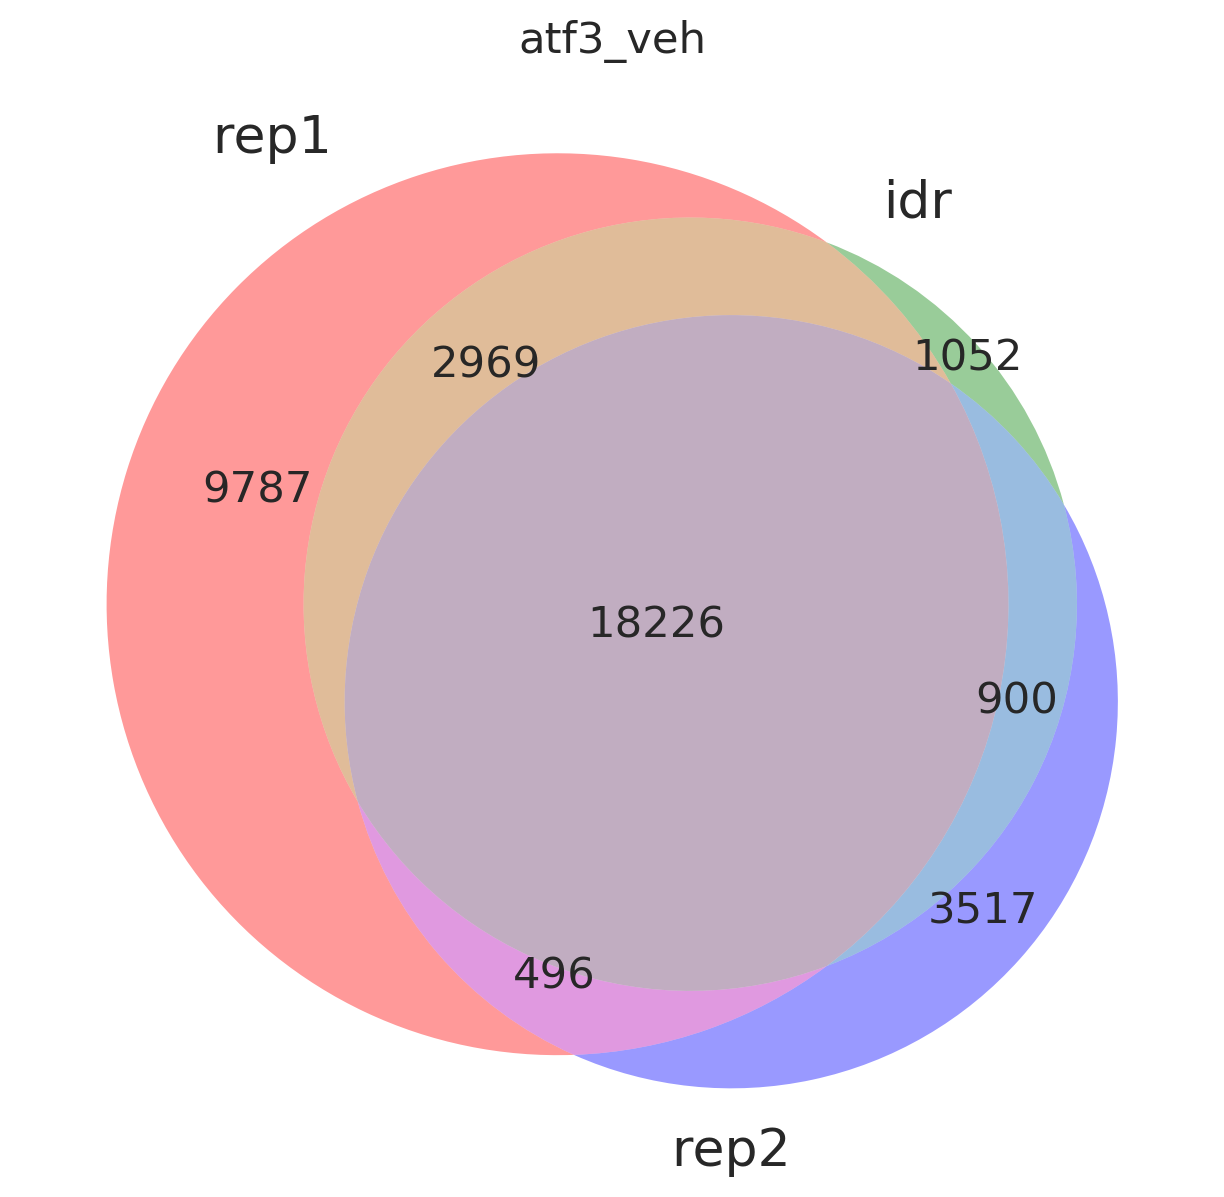

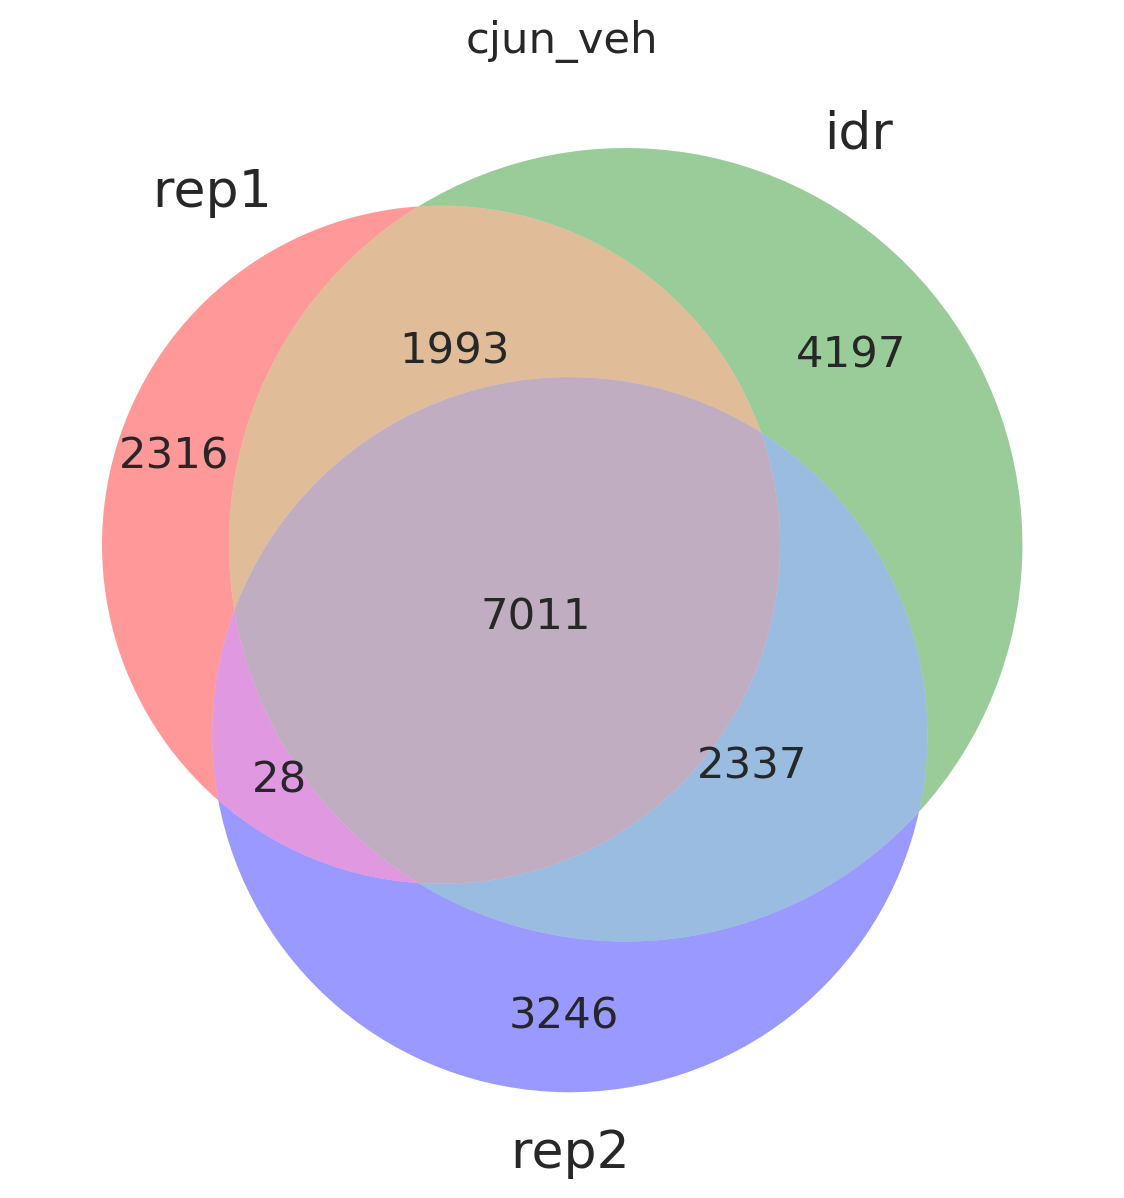

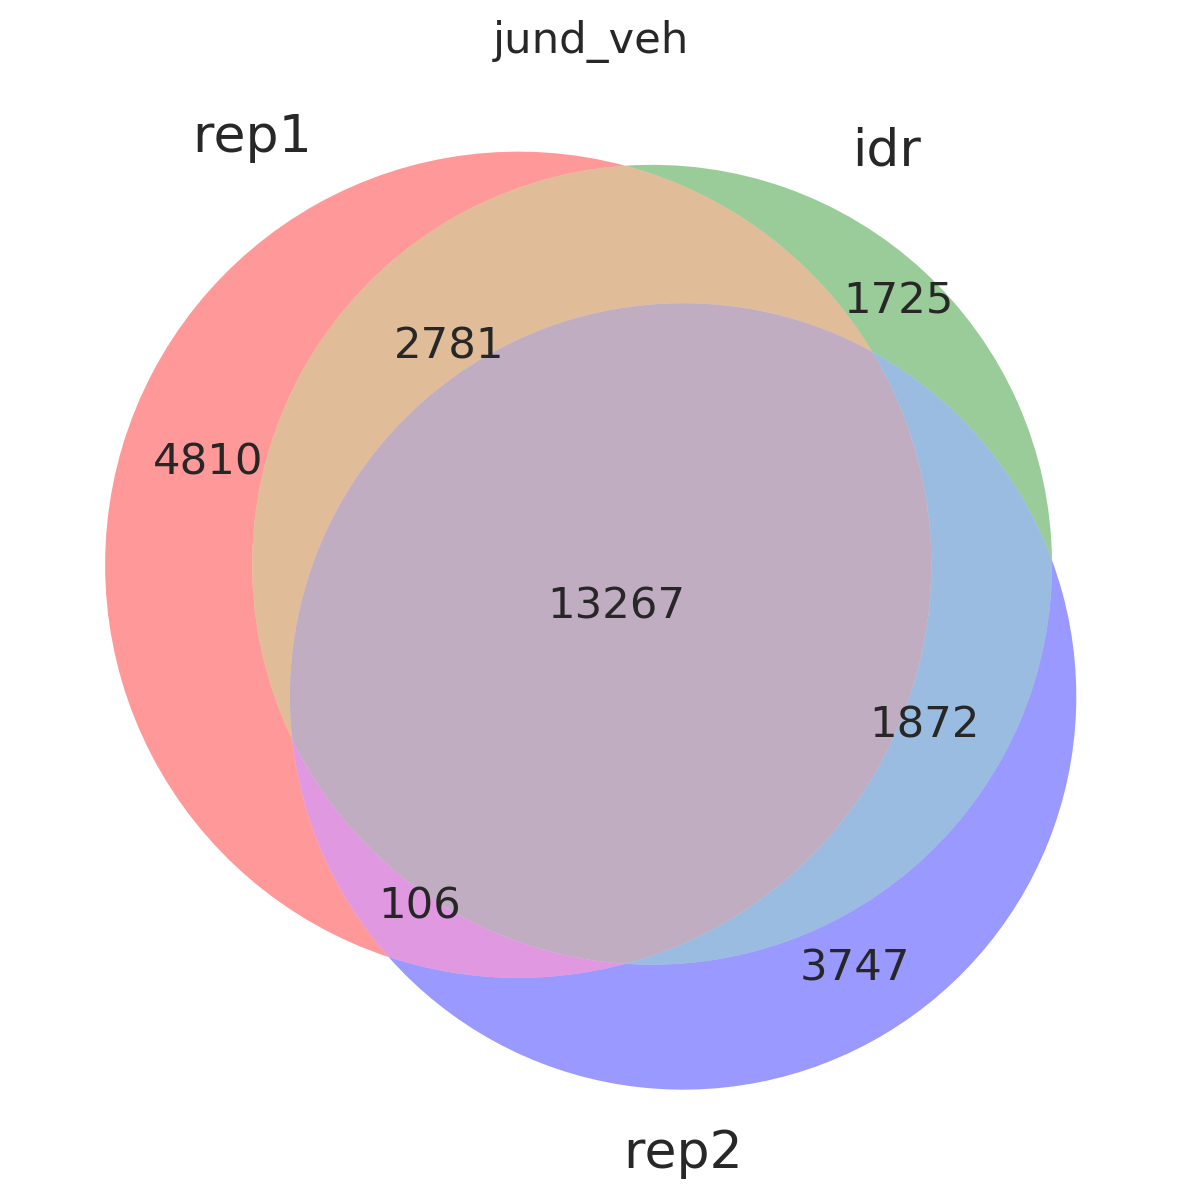

In [53]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund']:
        rep1_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'rep1'])] > 0].index.values)
        rep2_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'rep2'])] > 0].index.values)
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        matplotlib_venn.venn3([rep1_indices, idr_indices, rep2_indices], set_labels=['rep1', 'idr', 'rep2'])
        plt.title('_'.join([factor, treatment]))
        plt.show()

## Visualize Difference Between Monomers

In [54]:
def quantile_normalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

In [55]:
conditions = set()
for col in annotated_frame.columns[6:]:
    condition = '_'.join(col.split('_')[:2])
    conditions.add(condition)
annotated_mean_frame = annotated_frame[[]]
for condition in sorted(conditions):
    mean_tags = annotated_frame[[x for x in annotated_frame.columns if condition in x]].mean(axis=1)
    annotated_mean_frame[condition] = mean_tags.values

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
indices = set()
factors=['atf3', 'cjun', 'jund']
for treatment in ['veh']:
    for factor in factors:
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        indices = indices.union(idr_indices)
indices = sorted(indices)
data = annotated_mean_frame[annotated_mean_frame.index.isin(indices)][['atf3_veh', 'cjun_veh', 'jund_veh']]
data = data[data.min(axis=1)>0]
normed_mean_data = data[[]]
for col in data:
    normalized_vals_1, normalized_vals_2 = quantile_normalize(data['atf3_veh'].values, data[col].values)
    normed_mean_data[col] = normalized_vals_2


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
medians = normed_mean_data.median(axis=1)
mins = normed_mean_data.min(axis=1)
maxes = normed_mean_data.max(axis=1)
ranges = maxes - mins
normed_distances = normed_mean_data[[]]
for col in data:
    normed_distances[col] = (data[col].values- medians)/ranges

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


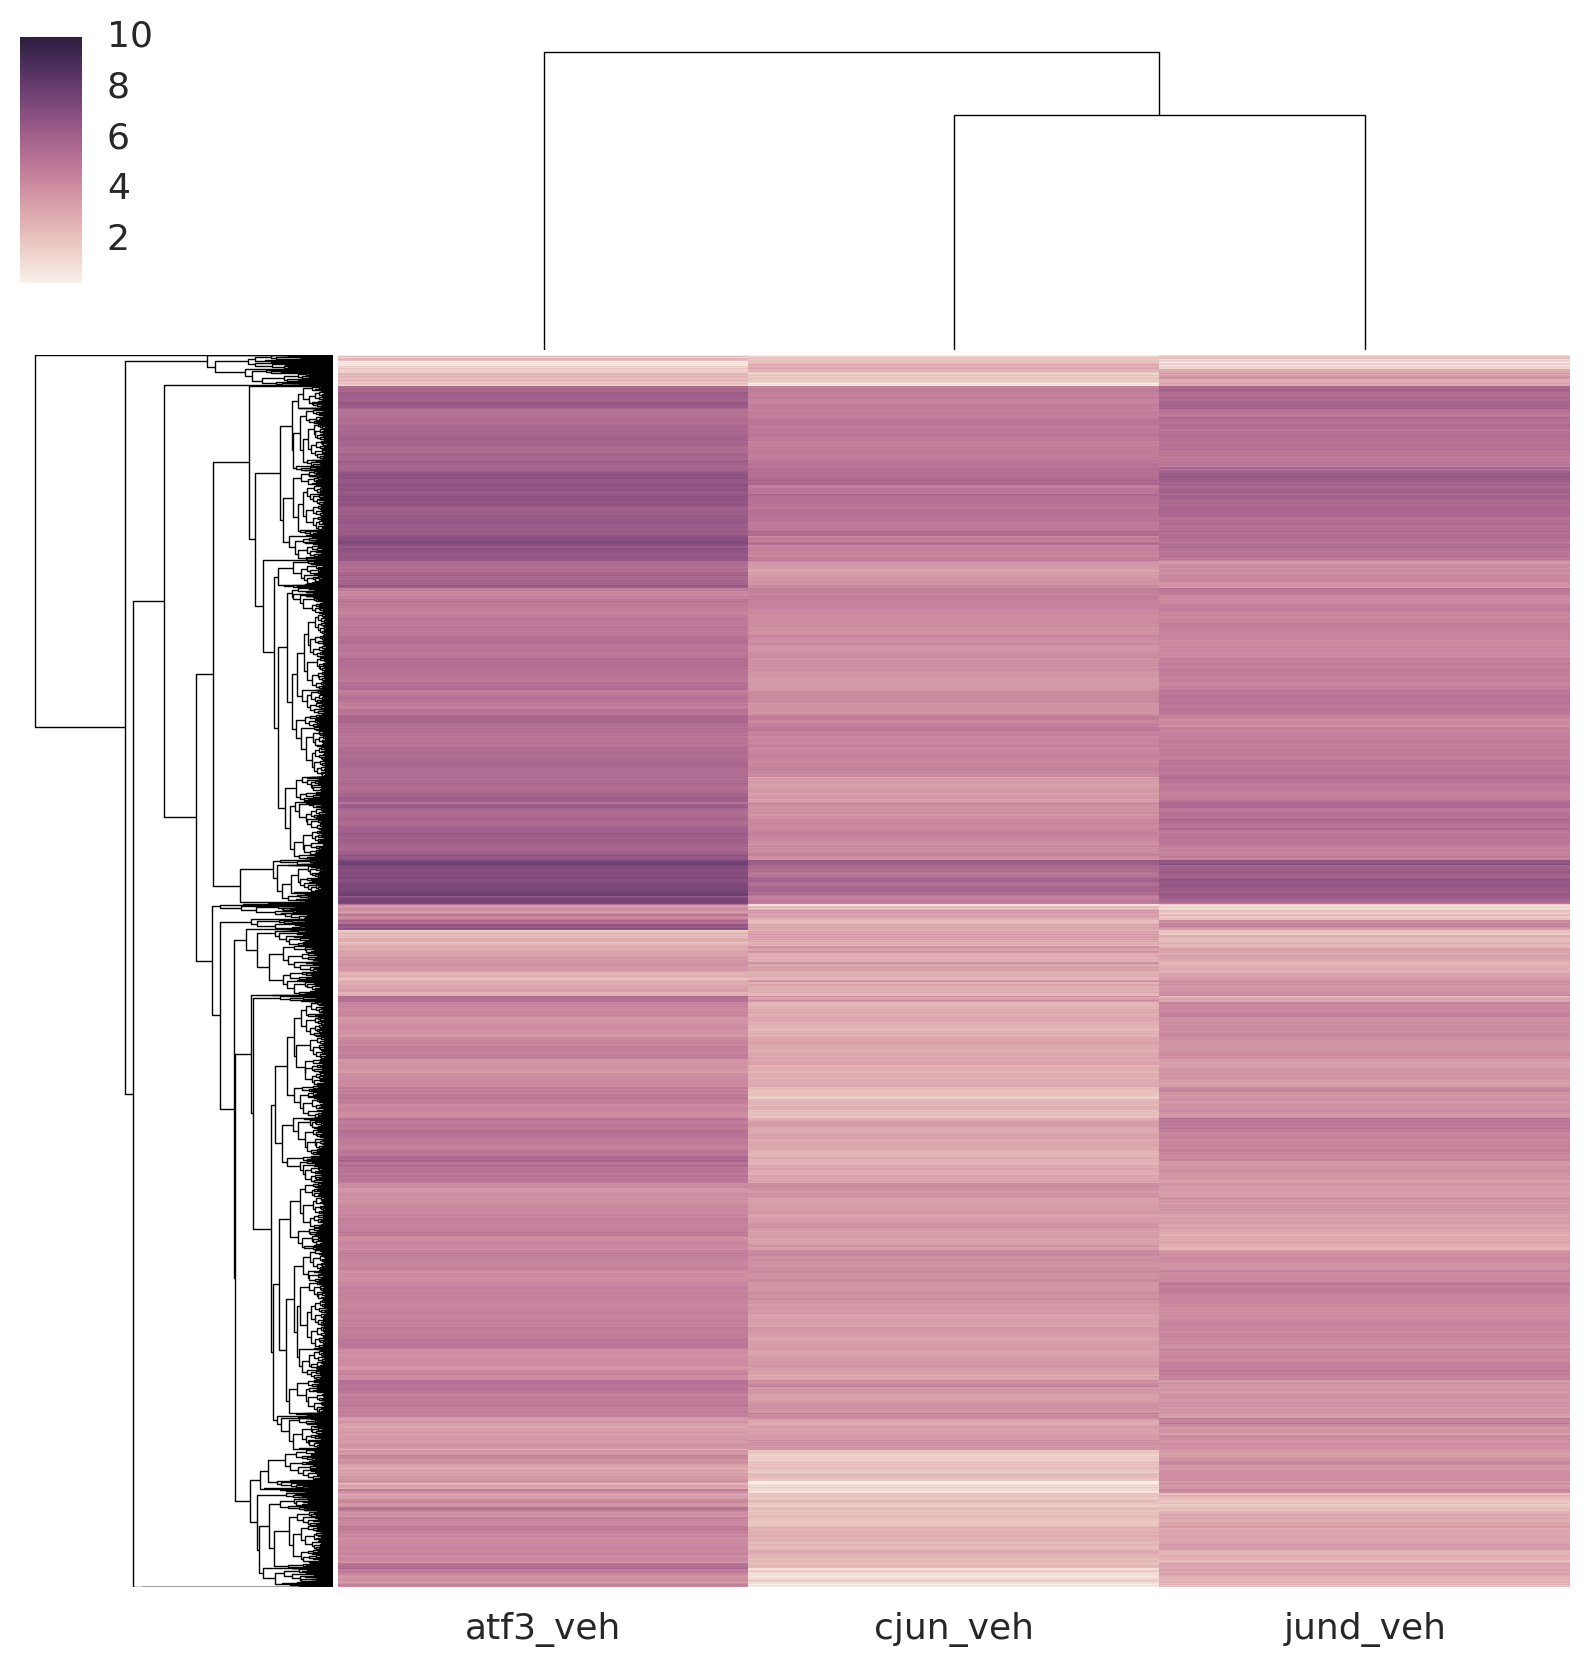

In [58]:
sns.clustermap(np.log2(data+1), 
               yticklabels=False,
               vmax=10,
#                metric = 'correlation',
#                method = 'centroid'
              )

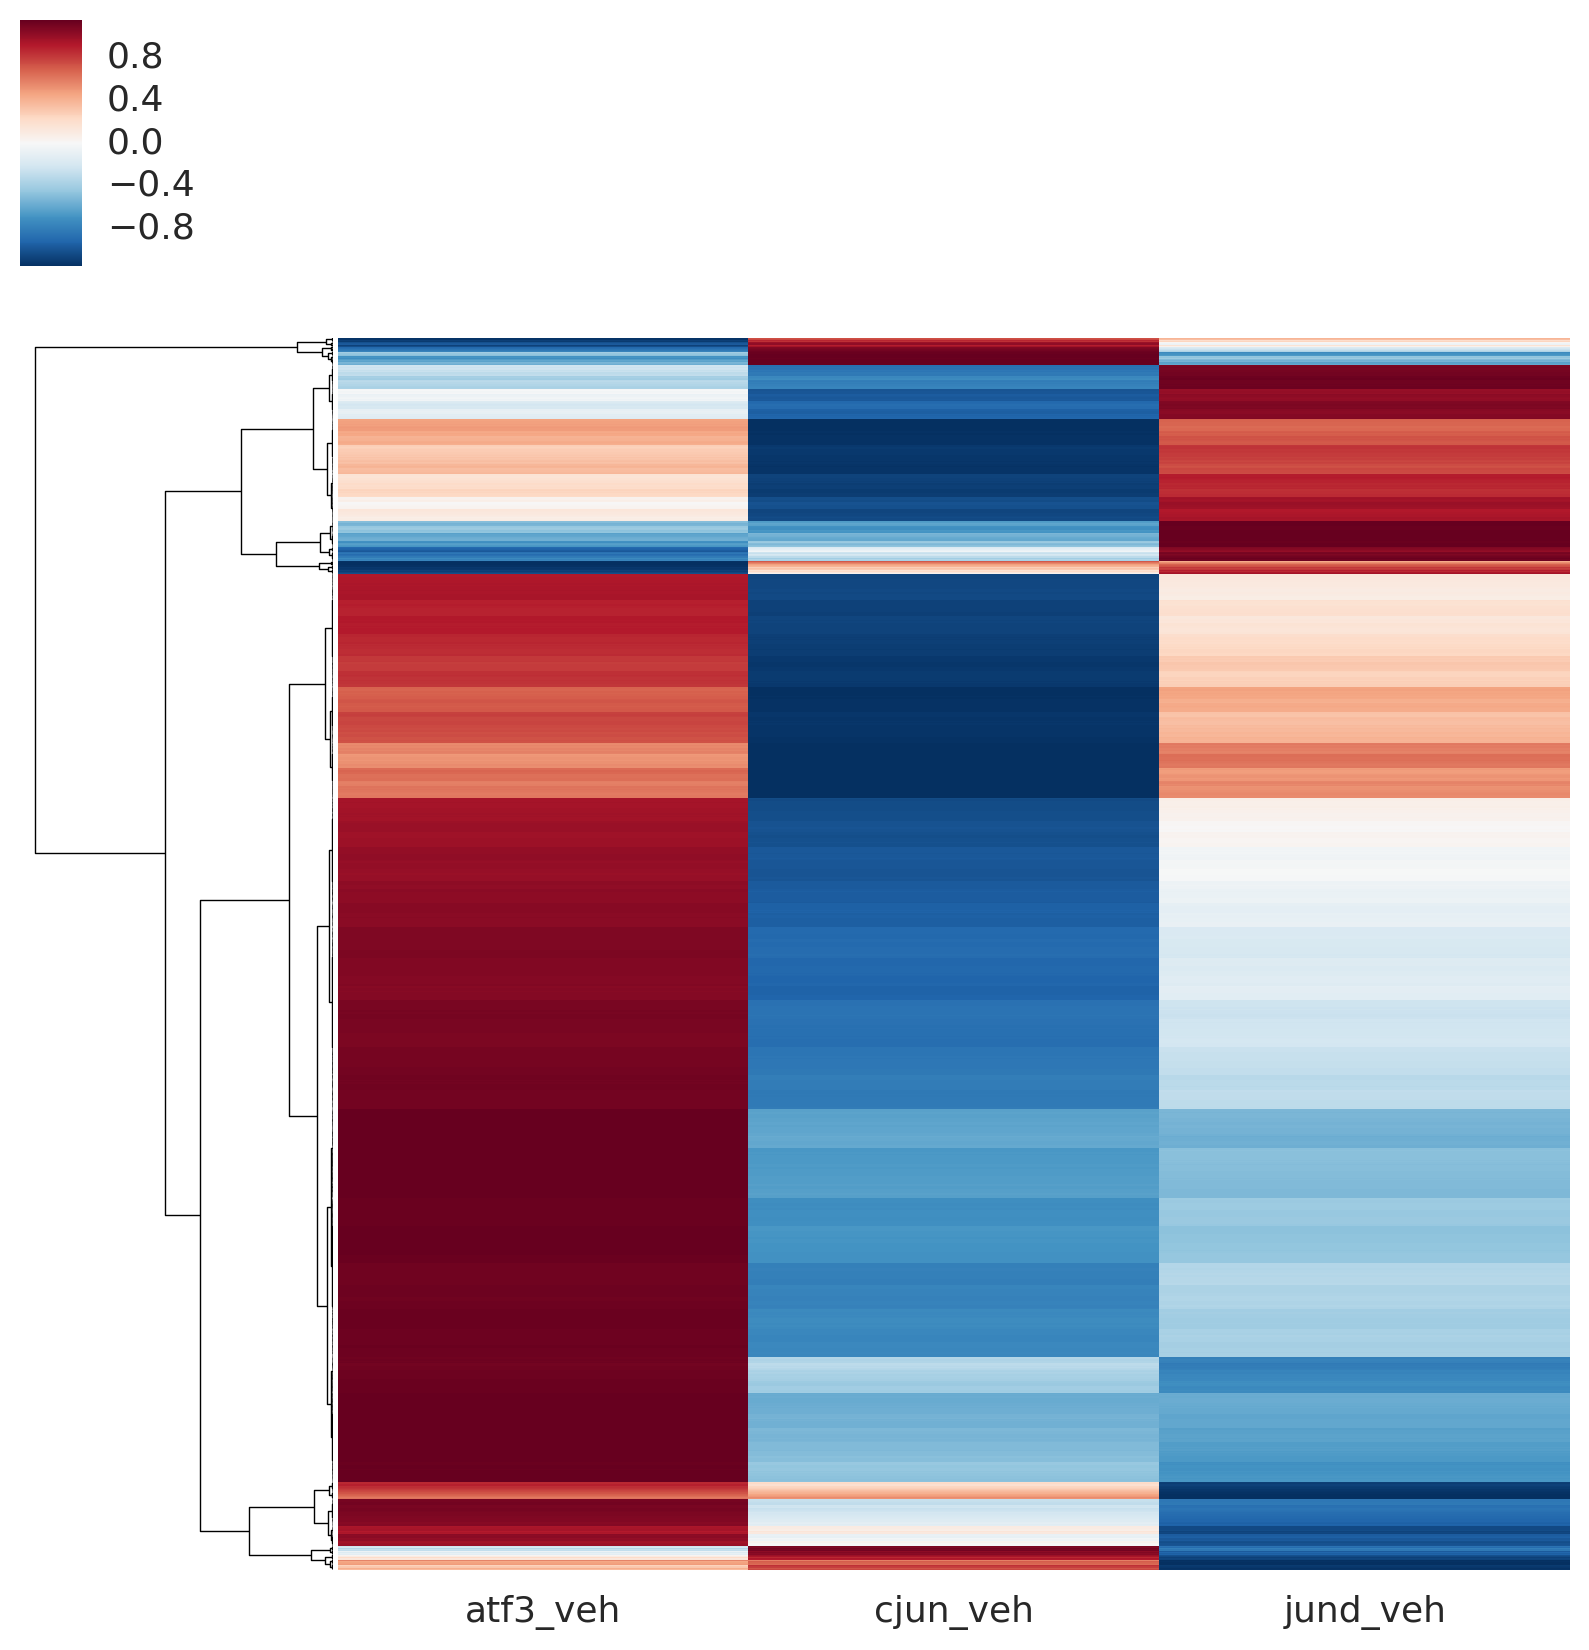

In [59]:
cg = sns.clustermap(data,
                    yticklabels=False,
                    col_cluster=False,
                    z_score=0,
                    metric = 'correlation',
                    method = 'centroid')

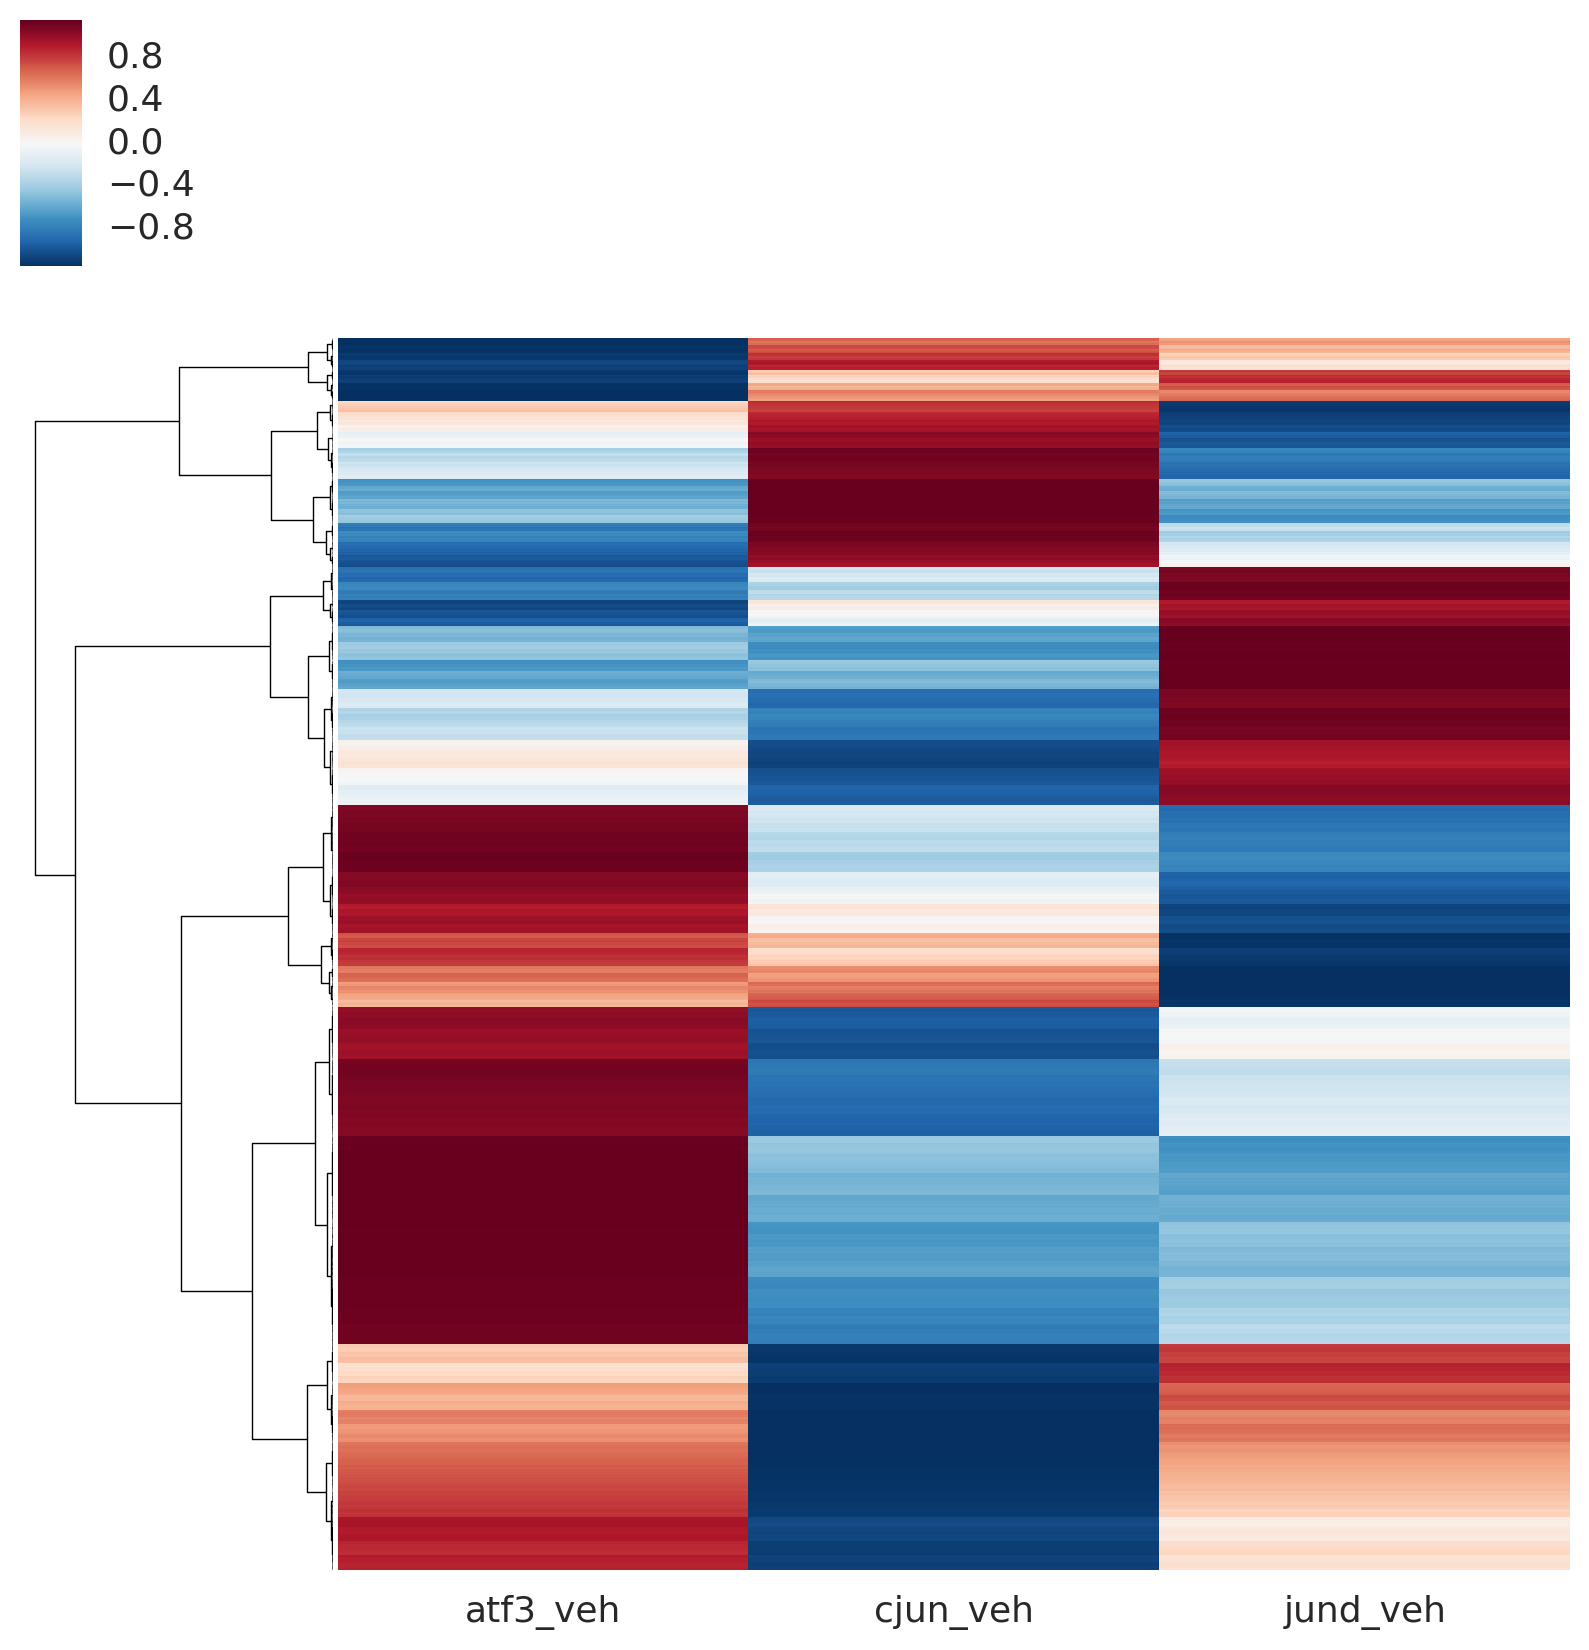

In [60]:
cg = sns.clustermap(normed_mean_data,
                    yticklabels=False,
                    z_score=0,
                    col_cluster=False,
                    metric = 'correlation',
                    method = 'centroid')

In [61]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

(29783, 6)
(27834, 6)
(27834, 6)


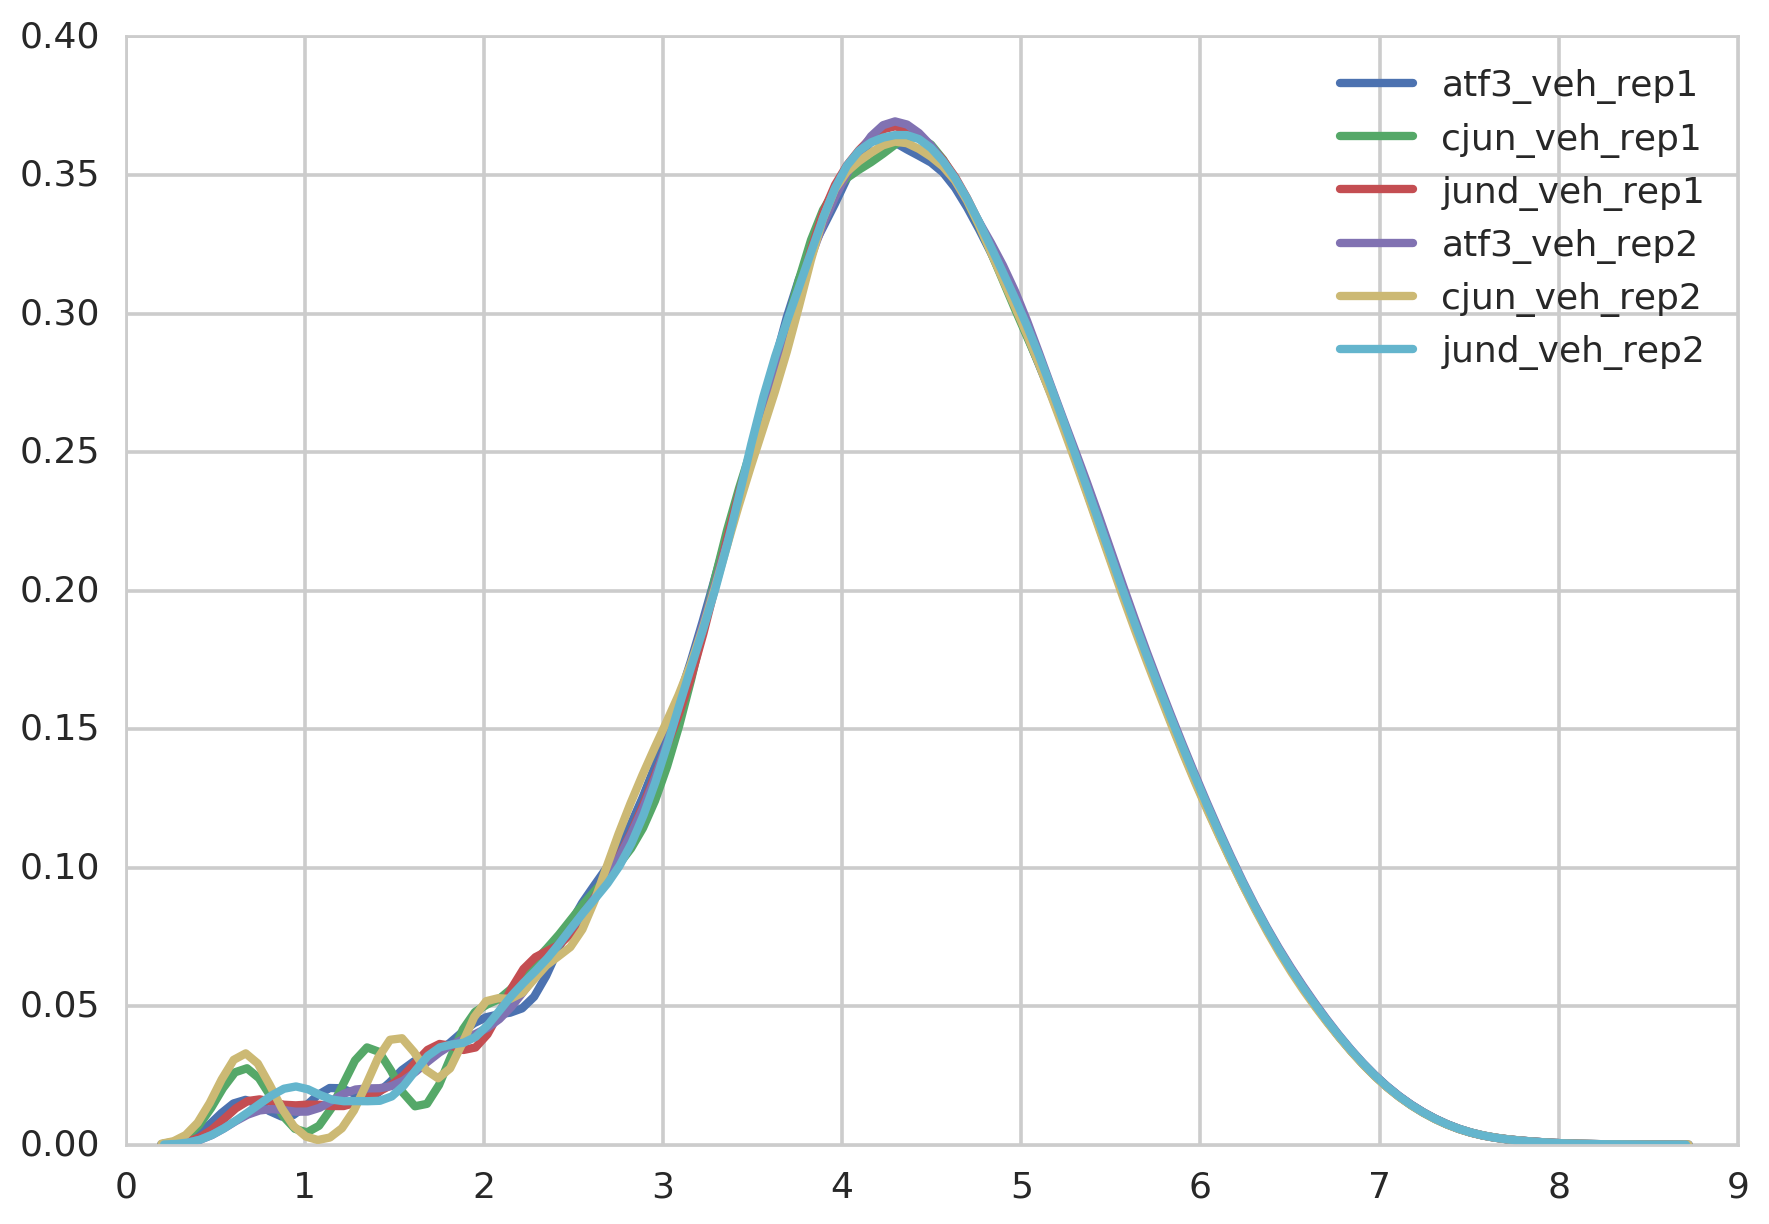

In [62]:
indices = set()
factors=['atf3', 'cjun', 'jund']
treatment = 'veh'
for factor in factors:
    idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
    indices = indices.union(idr_indices)
indices = sorted(indices)
rep_cols = [f + '_' + treatment + '_rep1' for f in factors] + [f + '_' + treatment + '_rep2' for f in factors]
data = annotated_frame[annotated_frame.index.isin(indices)][rep_cols]
print(data.shape)
data = data[data.min(axis=1)>0]
print(data.shape)
# data = data[data.max(axis=1) >= 16]
print(data.shape)
normed_data = data[[]]
mean_vals = data.mean(axis=1)
quant_normed_data = quantile_normalize_df(data)

for col in data:
    with sns.axes_style('whitegrid'):
        sns.kdeplot(np.log2(quant_normed_data[col]+1), label = col, linewidth=3)
#         sns.kdeplot(np.log2(data[col]+1), label = col, linewidth=3)

(27834, 6)


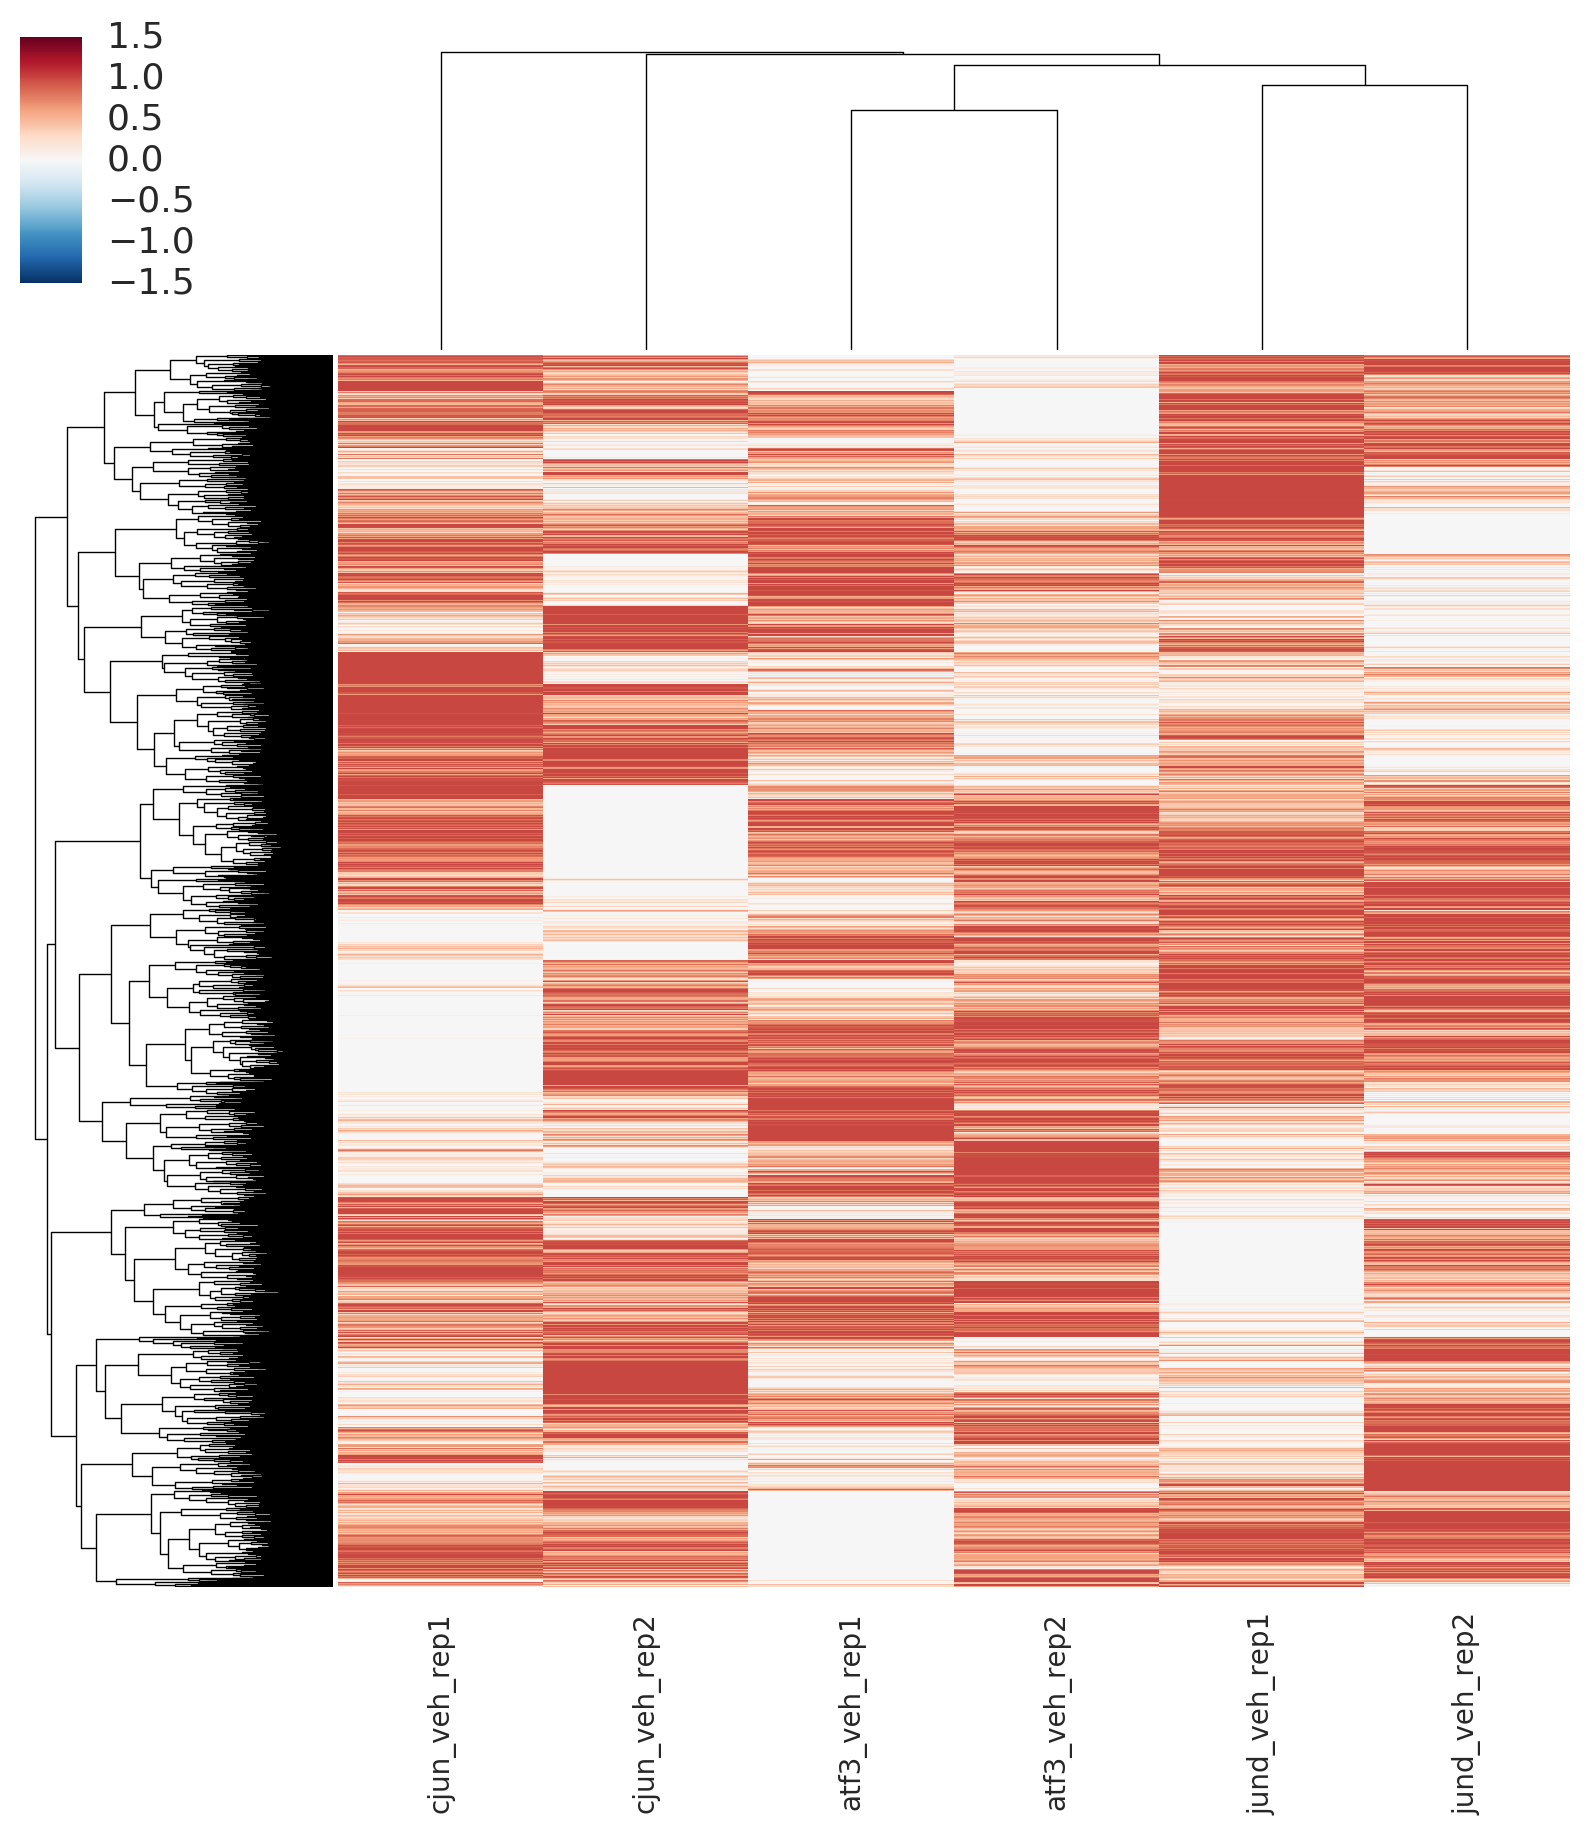

In [64]:
to_plot = quant_normed_data
print(to_plot.shape)
cg = sns.clustermap(np.log2(to_plot+1),
#                     to_plot,
                    yticklabels=False,
                    col_cluster=True,
#                     z_score=0,
#                     metric = 'correlation',
                    standard_scale =0,
#                     cmap='Blues',
                    vmin=-1.5,
                    vmax=1.5
                   )

plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

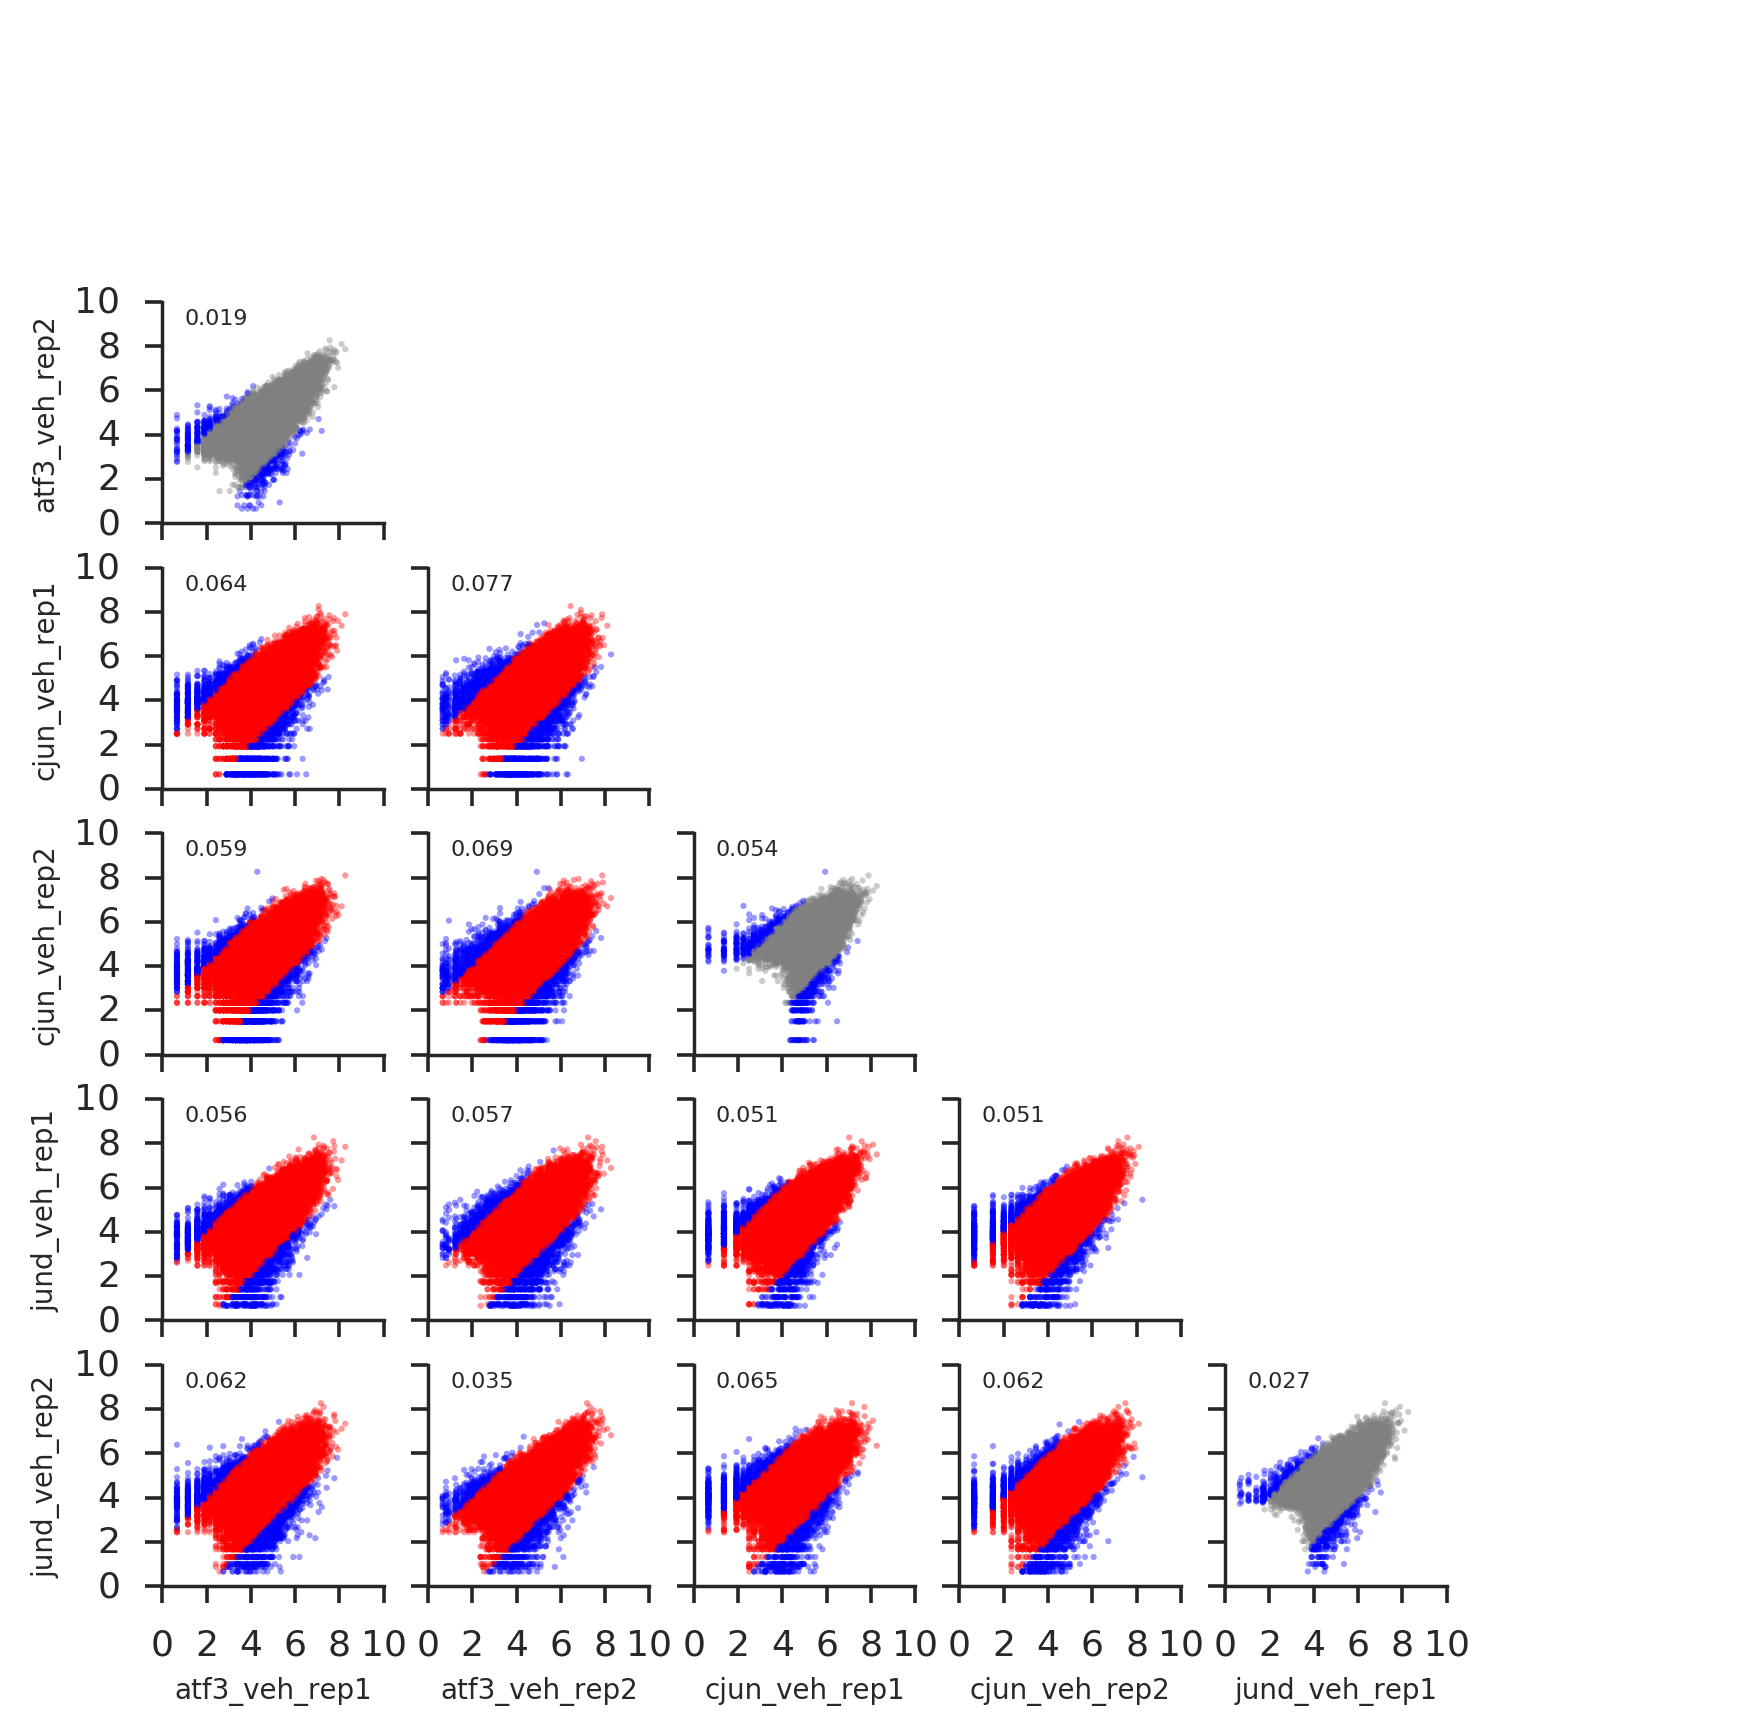

In [70]:
sns.set_style('ticks')
xlim=10
ylim=10
fold_threshold = 4
samples = quant_normed_data.columns.sort_values()
fig, axes_array = plt.subplots(len(samples), len(samples), figsize=(10,10));
for i in range(len(samples)):
    samp1 = samples[i]
    ft1 = '_'.join(samp1.split('_')[:2])
    axes_array[len(samples) - 1][i].set_xlabel(samp1, size=10)
    axes_array[i][0].set_ylabel(samp1, size=10)
    for j in range(i,len(samples)):
    
        ax = axes_array[j][i]
        axes_array[i][j].axis('off')
        samp2 = samples[j]
        ft2 = '_'.join(samp2.split('_')[:2])
        if samp1 != samp2:
            if ft1 == ft2:
                indices = summary_frame[(summary_frame[samp1] > 0) |
                    (summary_frame[samp2] > 0)].index.values # identify loci that has binding of monomer
            else:
                indices =  summary_frame[(summary_frame[ft1+'_idr'] > 0) |
                    (summary_frame[ft2+'_idr'] > 0)].index.values

            # plot replicates against each other
#             to_plot_data = annotated_frame[annotated_frame.index.isin(indices)][[samp1, samp2]]
            to_plot_data = quant_normed_data[quant_normed_data.index.isin(indices)][[samp1, samp2]]
            to_plot_data = to_plot_data[to_plot_data.max(axis=1) >= 4]
            rep1_vals = to_plot_data[samp1]
            rep2_vals = to_plot_data[samp2]
            logged_rep1_vals = np.log2(rep1_vals + 1)
            logged_rep2_vals = np.log2(rep2_vals + 1)

#             pearson, pval = scipy.stats.pearsonr(rep1_vals, rep2_vals)
#             pearson, pval = scipy.stats.pearsonr(logged_rep1_vals, logged_rep2_vals)
            color_list = []
            fold_count = 0
            for t in zip(rep1_vals, rep2_vals):
                fold = (t[0]+1)/(t[1]+1)
                if fold >= fold_threshold or fold <= 1/fold_threshold:
                    color_list.append('blue')
                    fold_count+=1
                else:
                    if ft1 == ft2:
                        color_list.append('grey')
                    else:
                        color_list.append('red')
                    
            
            ax.scatter(logged_rep1_vals, logged_rep2_vals, 
                       c = color_list,
                       marker = 'o', s = 5,
                       edgecolor='None',
                       alpha=0.4
                       )

#             ax.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)
            ax.annotate(xy=(1,ylim - 1), s=str(fold_count/len(color_list))[:5], size=8)
            ax.set_xlim(0,xlim)
            ax.set_ylim(0,ylim)
            ax.set_aspect(1)

            sns.despine()   
            if j < len(samples) - 1:
                ax.set_xticklabels([])
            if i > 0:
                ax.set_yticklabels([])
        else:
            ax.axis('off')
            

## Compare Models

### Read in Weights

In [56]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[1:4])
        sample_weights_dict[sample] = mean_weights

mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### Compare Weights

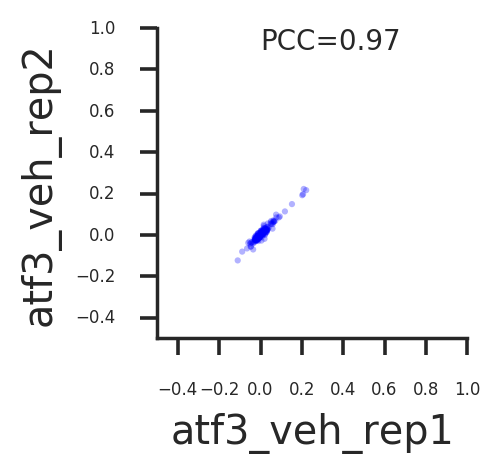

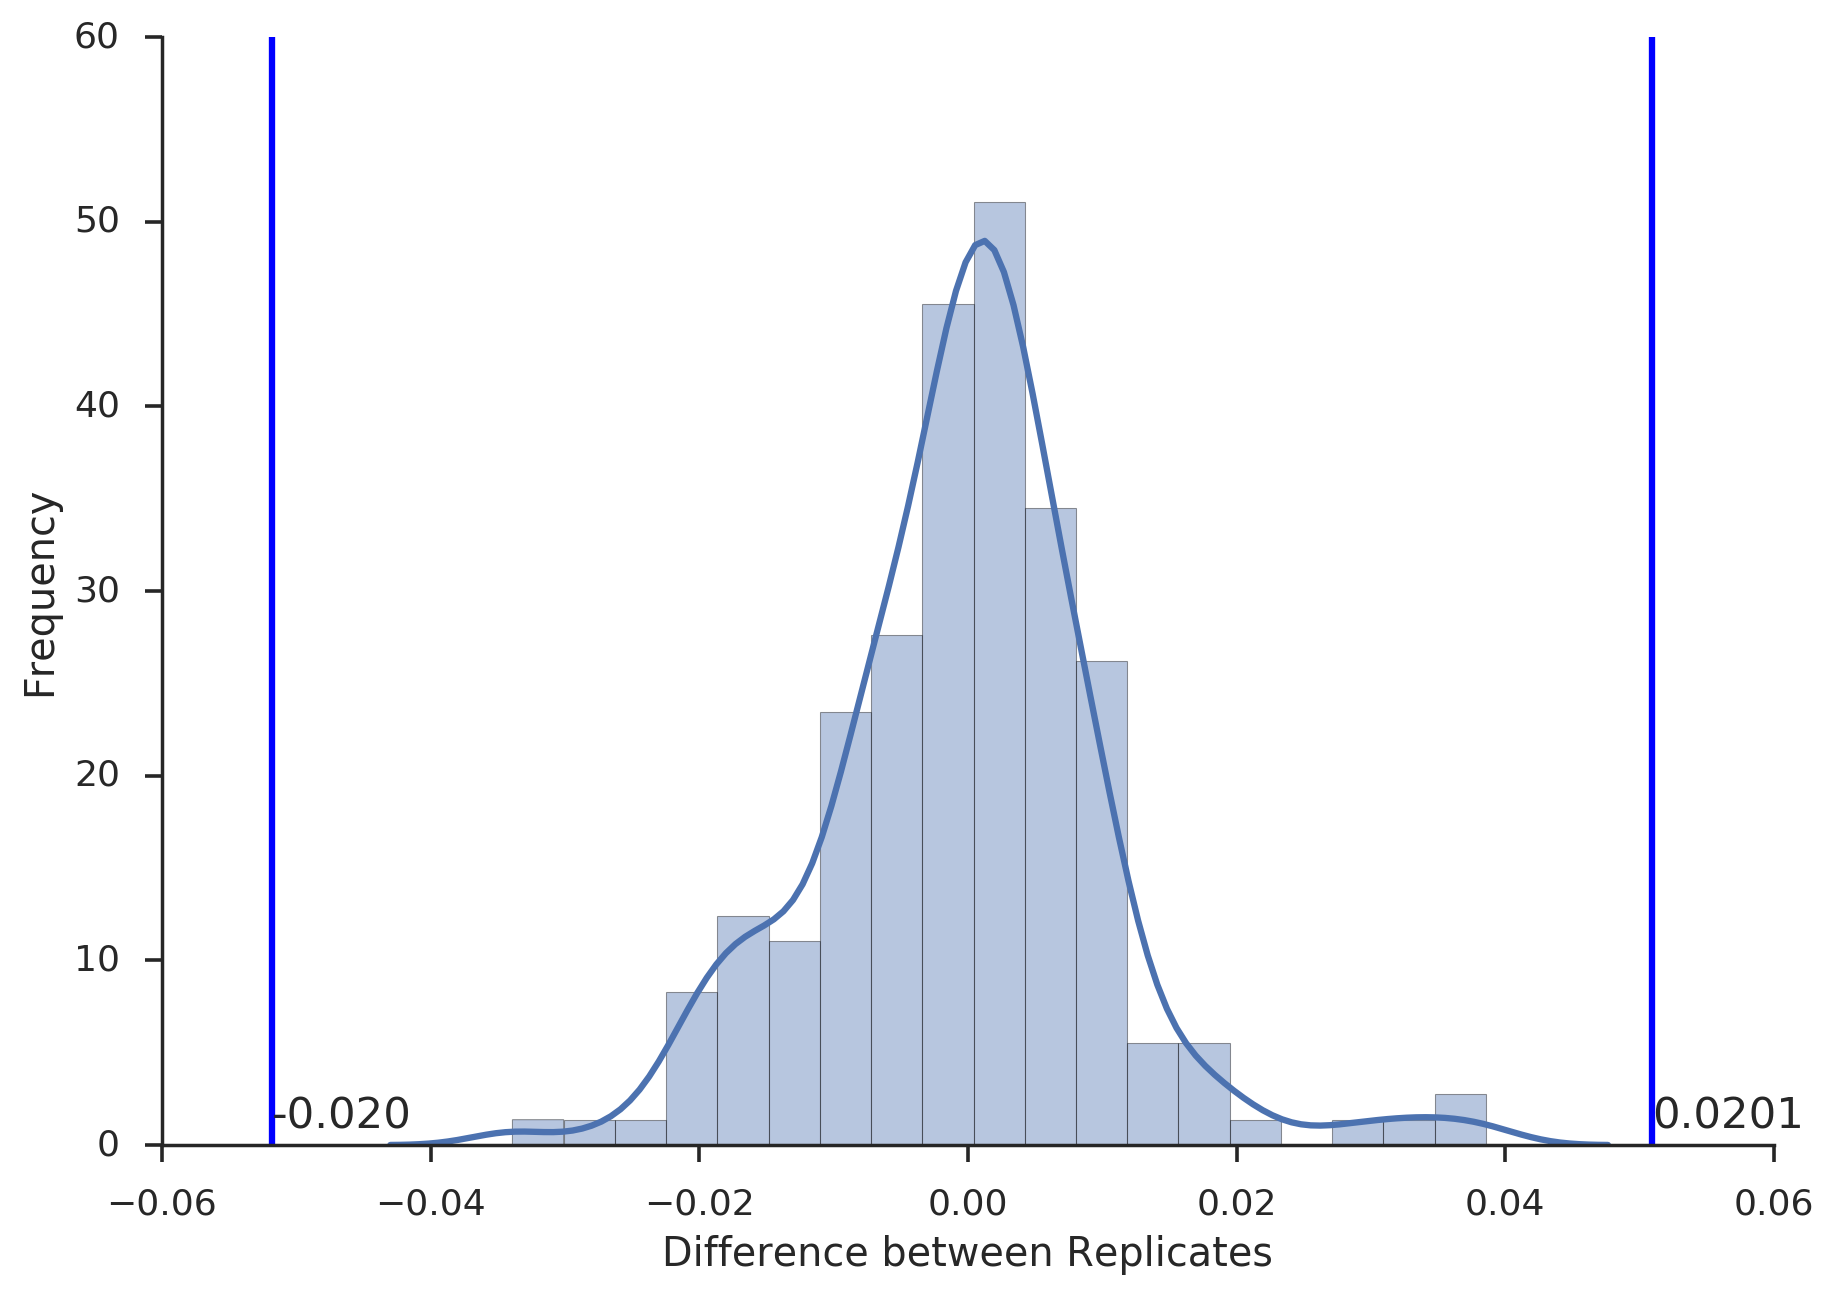

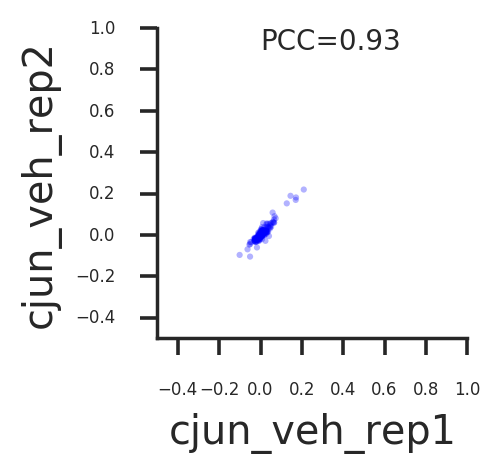

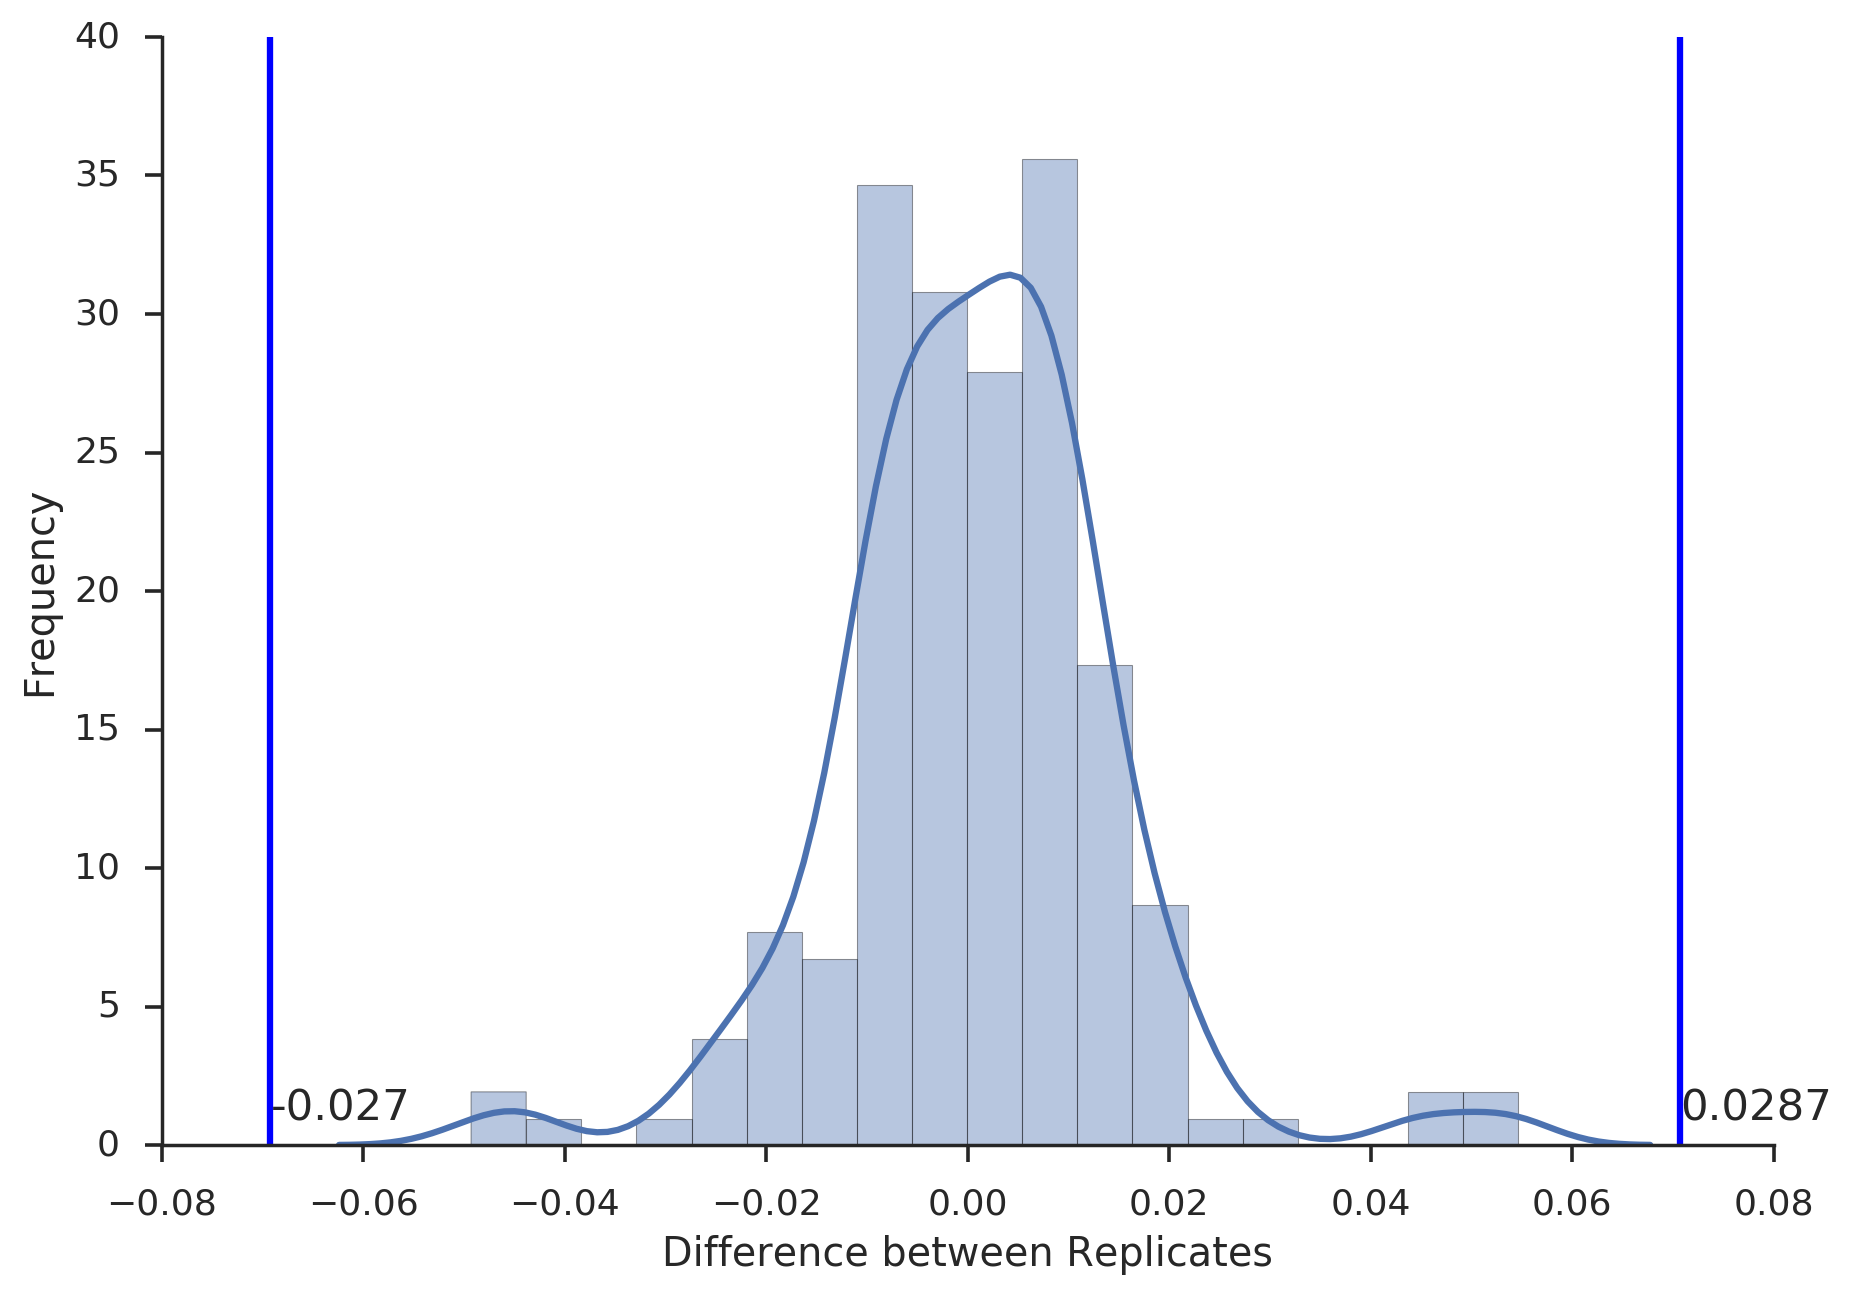

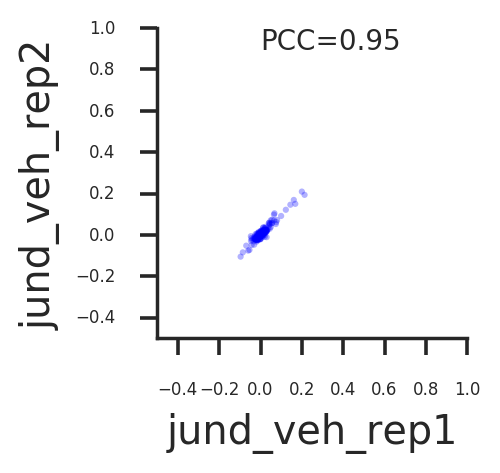

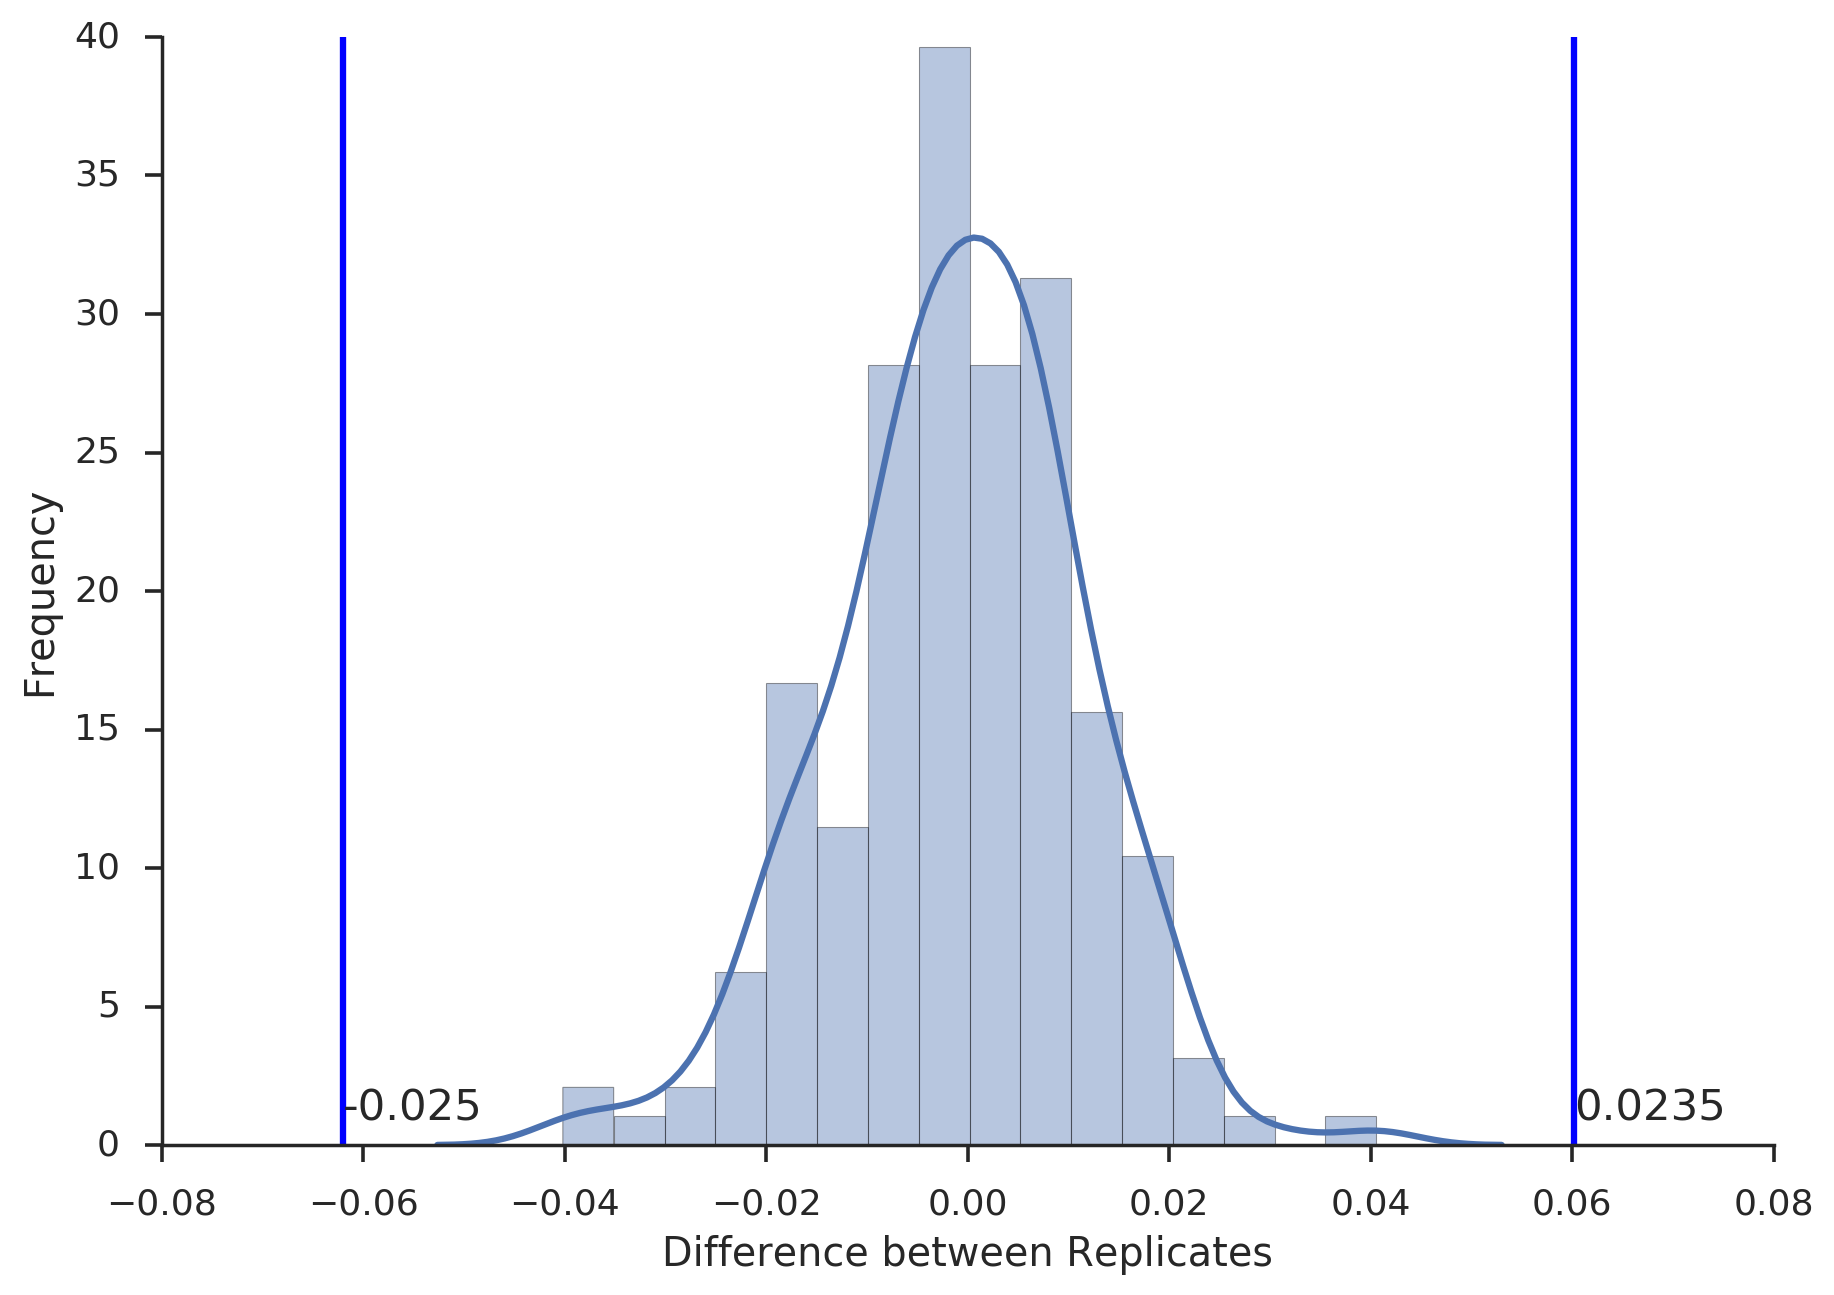

In [64]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund']:
        rep1_label = '_'.join([factor, treatment, 'rep1'])
        rep2_label = '_'.join([factor, treatment, 'rep2'])
        idr_label = '_'.join([factor, treatment, 'idr'])
        
        rep1_weights = pd.Series(data=mean_weights_frame[rep1_label].values,
                                 index=mean_weights_frame.index.values)
        rep2_weights = pd.Series(data=mean_weights_frame[rep2_label].values,
                                 index=mean_weights_frame.index.values)
        
        idr_weights = pd.Series(data=mean_weights_frame[idr_label].values,
                                index=mean_weights_frame.index.values)
        
        rep_corr, pval = scipy.stats.pearsonr(rep1_weights, rep2_weights)
        rep1_corr, pval = scipy.stats.pearsonr(idr_weights, rep1_weights)
        rep2_corr, pval = scipy.stats.pearsonr(idr_weights, rep2_weights)
        
        with sns.axes_style('ticks'):
            plt.figure(figsize=(2,2))
#             plt.scatter(np.exp(rep1_weights),
#                         np.exp(rep2_weights),
#                         edgecolor='None', 
#                         s=5,
#                         alpha=0.3)
            plt.scatter(rep1_weights,
                        rep2_weights,
                        edgecolor='None', 
                        s=5,
                        alpha=0.3)
#             plt.annotate(xy=(1,2.5), s='PCC='+str(rep_corr)[:4], size=10)
#             plt.xlim(0.5, 3)
#             plt.ylim(0.5, 3)
            plt.annotate(xy=(0,0.9), s='PCC='+str(rep_corr)[:4], size=10)
            plt.xlim(-0.5, 1)
            plt.ylim(-0.5, 1)
            ax = plt.gca()
            ax.set_aspect(1.0)
            plt.xlabel(rep1_label)
            plt.ylabel(rep2_label)
            plt.tick_params(axis='both', which='major', labelsize=6)
            sns.despine()
            plt.show()
#         small_weights = idr_weights[(np.exp(idr_weights) < 1.1)].index.values
        replicates_difference = pd.Series(rep1_weights-rep2_weights, 
                                          index = mean_weights_frame.index.values)
#         replicates_difference = pd.Series(np.exp(rep1_weights[rep1_weights.index.isin(small_weights)]) - \
#                                           np.exp(rep2_weights[rep2_weights.index.isin(small_weights)]), 
#                                           index = small_weights)
        sns.distplot(replicates_difference)
        std_dev = np.std(replicates_difference) * 2
        mean = np.mean(replicates_difference)
        plt.axvline(x=mean - 2.5*std_dev, ymin=0, ymax=1)
        plt.axvline(x=mean + 2.5*std_dev, ymin=0, ymax=1)
        plt.annotate(xy=(mean-2.5*std_dev, 0.9), s=str(mean-1*std_dev)[:6])
        plt.annotate(xy=(mean+2.5*std_dev, 0.9), s=str(mean+1*std_dev)[:6])
        plt.xlabel('Difference between Replicates')
        plt.ylabel('Frequency')
        sns.despine()
        
        plt.show()
#         plt.scatter(np.exp(idr_weights), abs(replicates_difference),
#                     edgecolor='None',
#                     s=5)
#         plt.xlabel('IDR motif odds ratio')
#         plt.ylabel('Odds Ratio between Reps')
#         plt.gca().set_aspect(1.0)
#         plt.show()
        
#         print(replicates_difference)

In [190]:
# odds_ratios = mean_weights_frame.ix[:, ['atf3_veh_idr', 'cjun_veh_idr', 'jund_veh_idr']].apply(np.exp)
odds_ratios = mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2', #'atf3_veh_idr',
                                              'cjun_veh_rep1', 'cjun_veh_rep2', #'cjun_veh_idr',
                                              'jund_veh_rep1', 'jund_veh_rep2', #'jund_veh_idr'
                                             ]].apply(np.exp)

In [278]:
filtered_odds_ratios = odds_ratios[((odds_ratios-1).abs() >= 0.1).max(axis=1)
                                   ]

In [121]:
mean_weights = mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2', 'atf3_veh_idr',
                                          'cjun_veh_rep1', 'cjun_veh_rep2', 'cjun_veh_idr',
                                          'jund_veh_rep1', 'jund_veh_rep2', 'jund_veh_idr'
                                             ]]

In [147]:
threshold = 50
data =mean_weights[mean_weights[
        [x for x in mean_weights.columns if 'idr' in x]
    ].rank(axis=0, ascending=False).min(axis=1) < threshold]

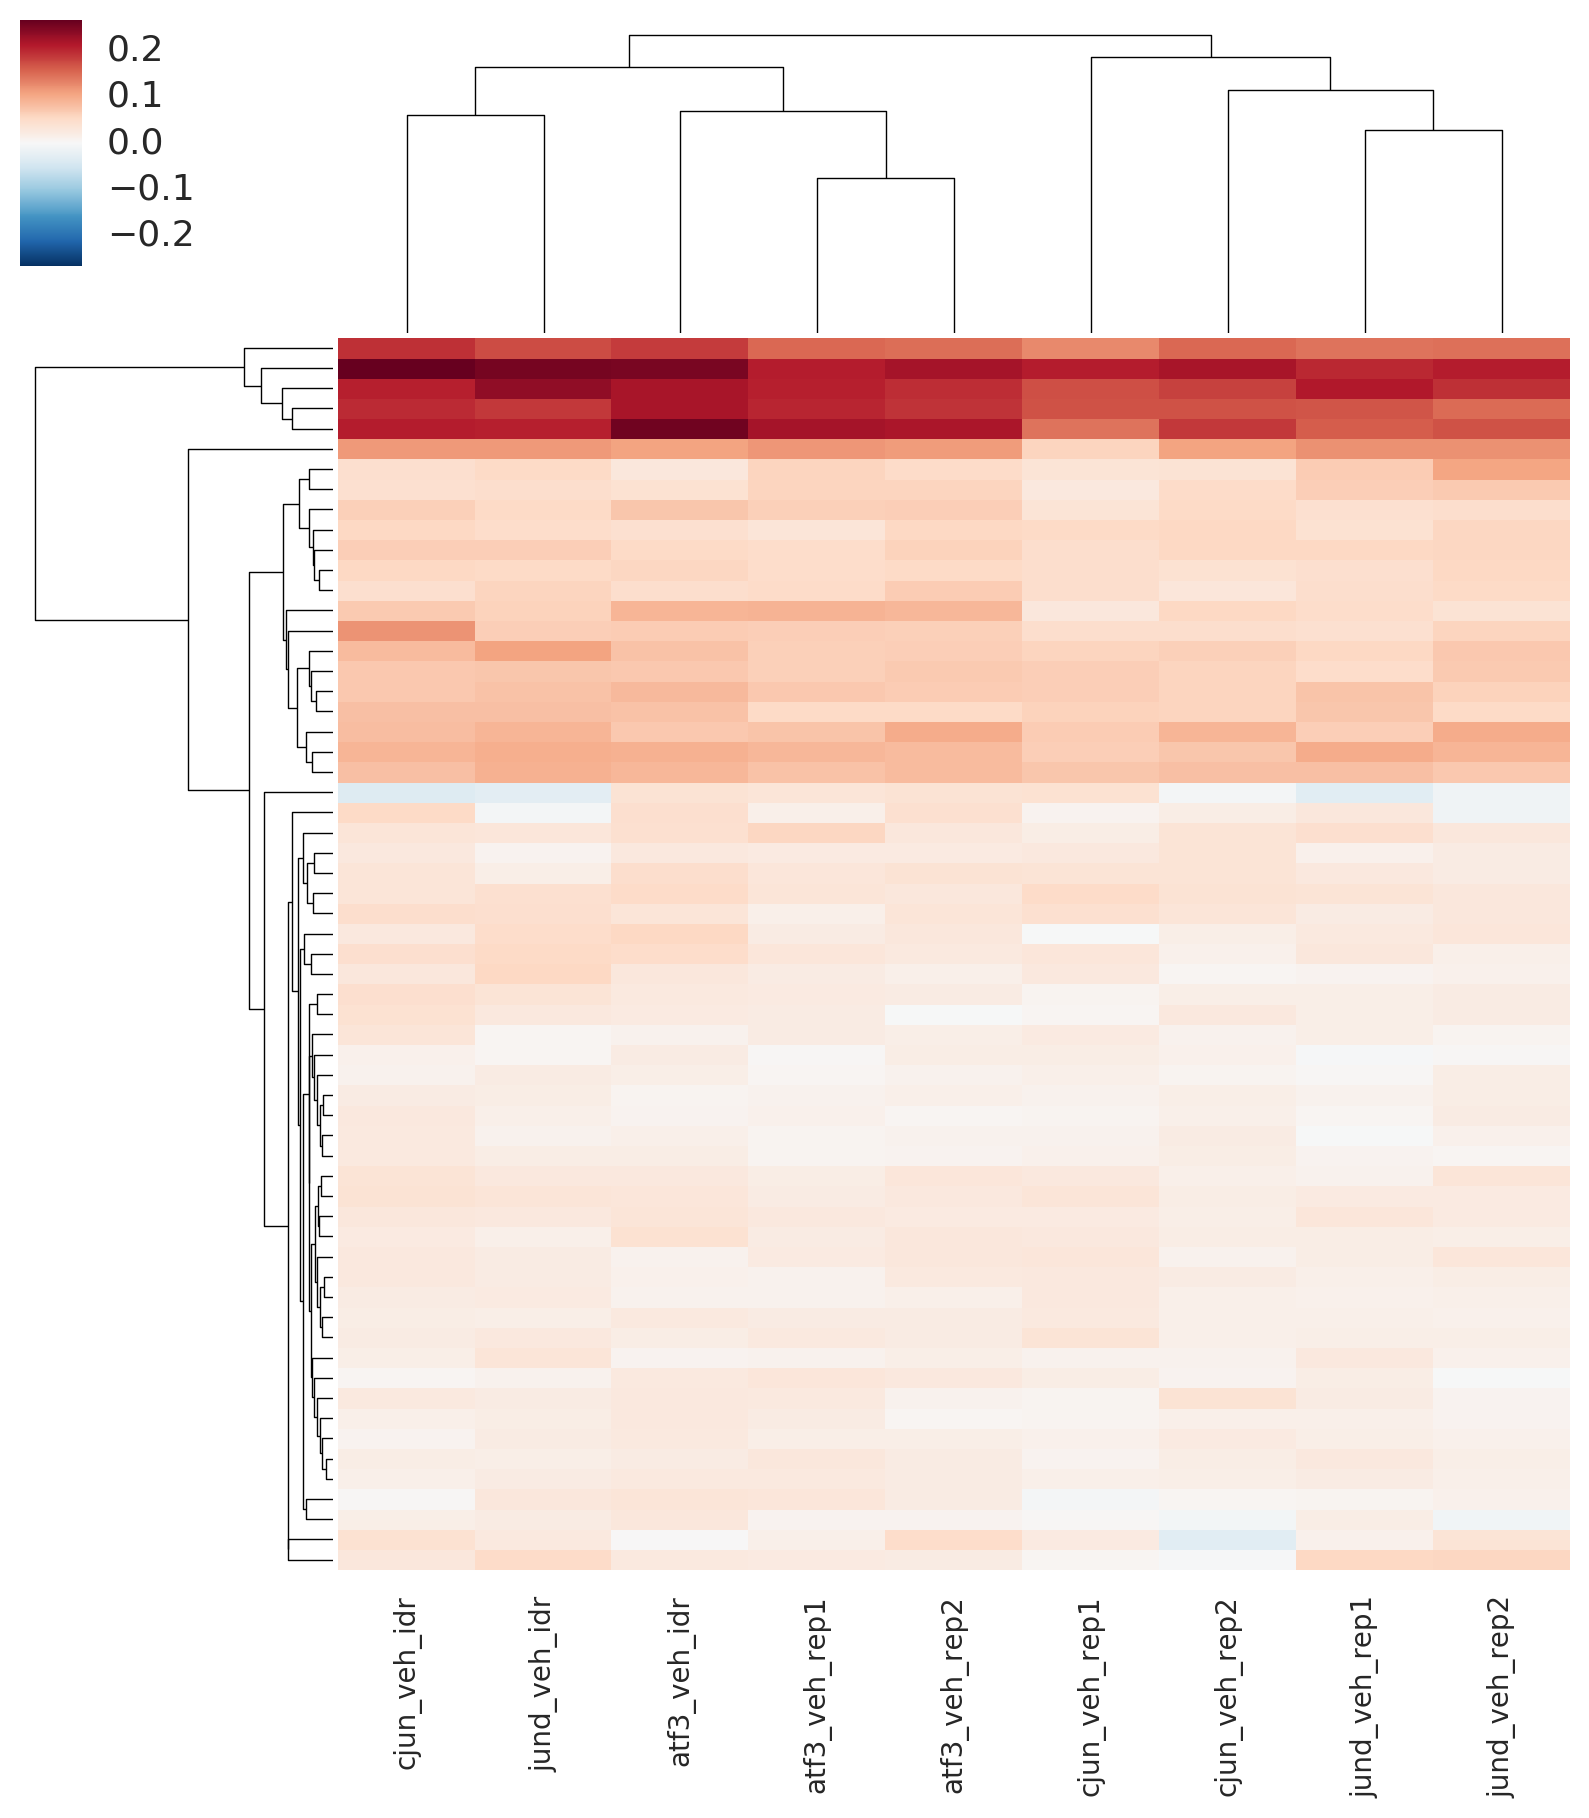

In [149]:
with sns.axes_style('darkgrid'):
    cm = sns.clustermap(data, 
#                         metric='correlation', 
#                         z_score=0,
#                         standard_scale=0,
#                         method = 'centroid',
                        yticklabels=False,
#                         vmin = -3,
#                         vmax = 3
                       )
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
             fontsize=7, 
             rotation=0);
    plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), 
             fontsize=10, 
             rotation=90);

### Odds Ratios

In [117]:
# odds_ratios = mean_weights_frame.ix[:, ['atf3_veh_idr', 'cjun_veh_idr', 'jund_veh_idr']].apply(np.exp)
odds_ratios = mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2', #'atf3_veh_idr',
                                              'cjun_veh_rep1', 'cjun_veh_rep2', #'cjun_veh_idr',
                                              'jund_veh_rep1', 'jund_veh_rep2', #'jund_veh_idr'
                                             ]].apply(np.exp)
filtered_odds_ratios = odds_ratios[((odds_ratios-1).abs() >= 0.05).max(axis=1)]

model = sklearn.decomposition.PCA(n_components=2)

reduced_features = model.fit_transform(filtered_odds_ratios.T)
explained_variance_ratios = model.explained_variance_ratio_

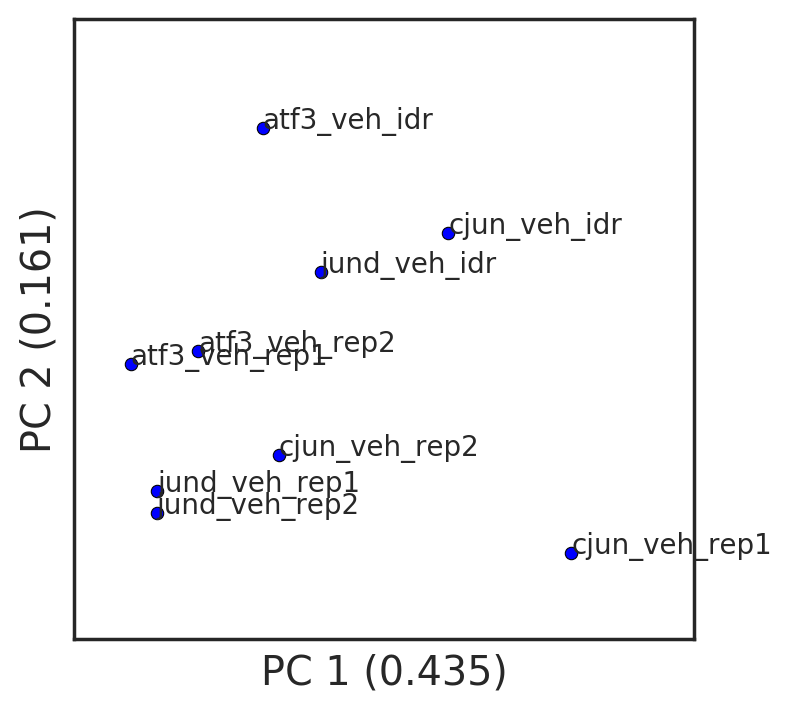

In [119]:
sns.set_style('white')
f = plt.figure(figsize=(4,4))
labels = [x for x in filtered_odds_ratios.columns.values]
# colors = ['red' if '_' in x else 'blue' for x in labels]
# 1st and 2nd principal component
x_vals = reduced_features[:, 0]
y_vals = reduced_features[:, 1]
plt.scatter(x_vals, y_vals, 
            s=20, 
#             c=colors
           )

for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        plt.annotate(labels[i], xy=(x,y) , size=10)

plt.xlabel("PC 1 (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("PC 2 (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
ax = plt.gca()
# x0,x1 = ax.get_xlim()
# y0,y1 = ax.get_ylim()
# ax.set_aspect(abs(x1-x0)/abs(y1-y0))






### Weights

In [262]:
mean_weights = mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2', #'atf3_veh_idr',
                                              'cjun_veh_rep1', 'cjun_veh_rep2', #'cjun_veh_idr',
                                              'jund_veh_rep1', 'jund_veh_rep2', #'jund_veh_idr'
                                             ]]

model = sklearn.decomposition.PCA(n_components=2)

reduced_features = model.fit_transform(mean_weights.T)
explained_variance_ratios = model.explained_variance_ratio_

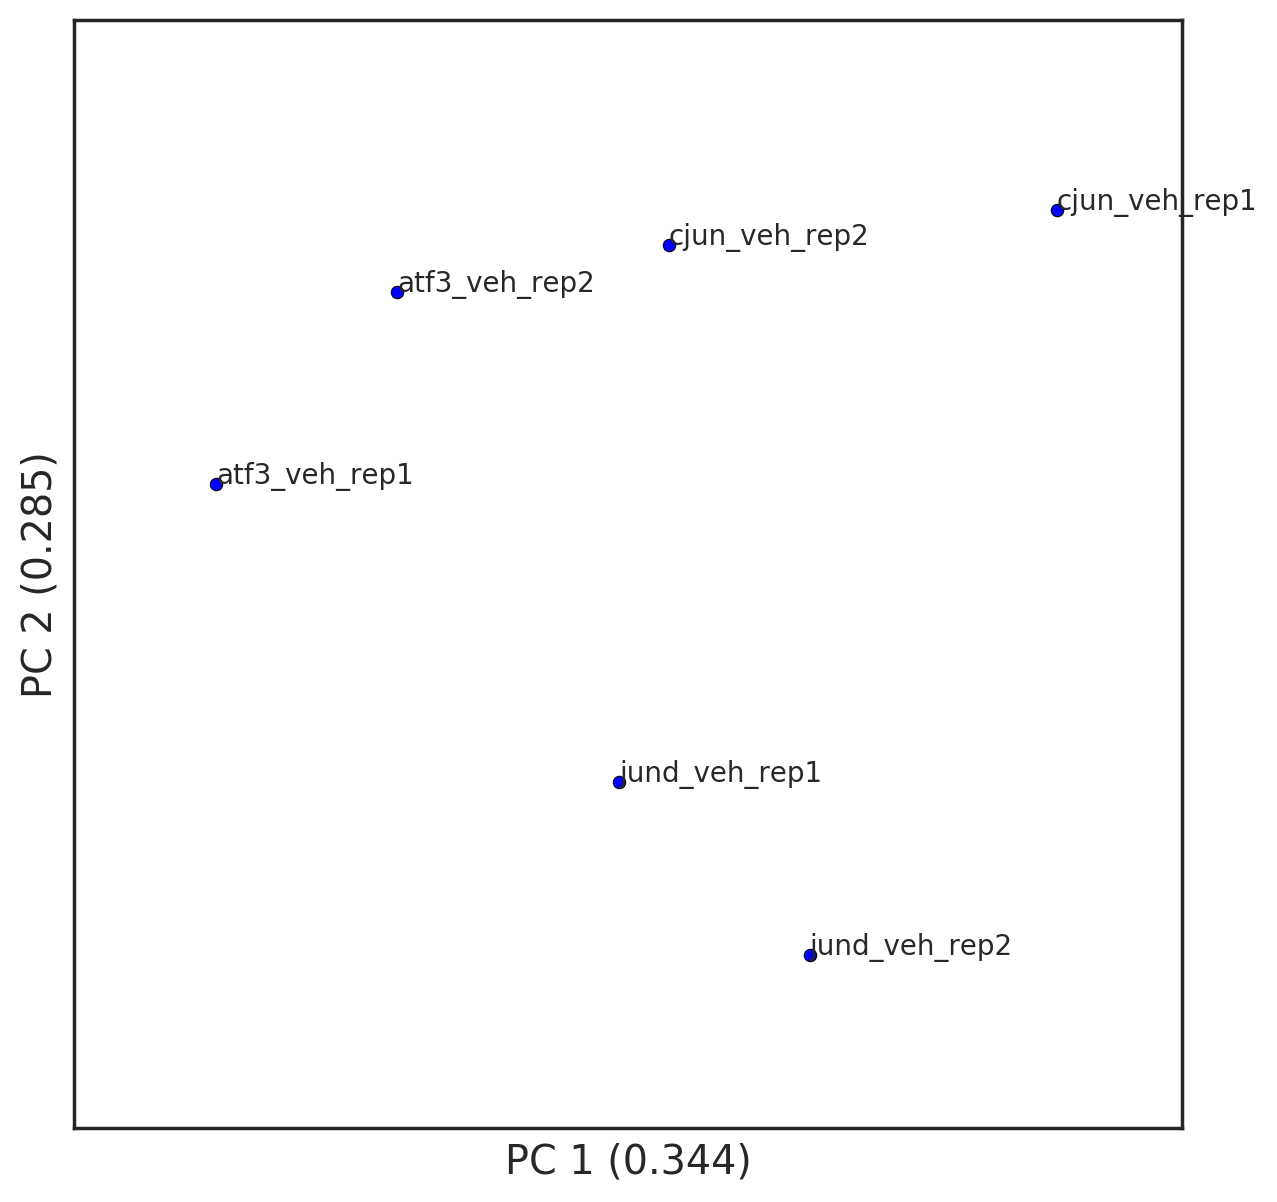

In [265]:
sns.set_style('white')
# f = plt.figure(figsize=(5,5))
labels = [x for x in mean_weights.columns.values]
# colors = ['red' if '_' in x else 'blue' for x in labels]
# 1st and 2nd principal component
x_vals = reduced_features[:, 0]
y_vals = reduced_features[:, 1]
plt.scatter(x_vals, y_vals, 
            s=20, 
#             c=colors
           )

for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        plt.annotate(labels[i], xy=(x,y) , size=10)

plt.xlabel("PC 1 (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("PC 2 (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))





### Compare P-vals

### Read in pvals

In [71]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_pval = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[1:4])
        sample_pval_dict[sample] = mean_pval

mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

In [107]:
monomers = sorted(set(([x.split('_')[0] for x in mean_pval_frame.columns])))
treatments =  sorted(set(([x.split('_')[1] for x in mean_pval_frame.columns])))

In [142]:
pseudocount = 1e-101
thresholds = [10**-x for x in np.arange(0,100,10.0)]
for m in monomers:
    for t in treatments:
        rep1 = '_'.join([m,t,'rep1'])
        rep2 = '_'.join([m,t,'rep2'])
        pvals_rep1 = mean_pval_frame[rep1] + pseudocount
        pvals_rep2 = mean_pval_frame[rep2] + pseudocount
        for thres in thresholds:
            significant_motifs_rep1 = set(pvals_rep1[pvals_rep1 < thres].index.values)
            significant_motifs_rep2 = set(pvals_rep2[pvals_rep2 < thres].index.values)
            intersect = significant_motifs_rep1.intersection(significant_motifs_rep2)
            union = significant_motifs_rep1.union(significant_motifs_rep2)
            print(m,t,thres, len(intersect), len(union))


atf3 kla 1.0 159 189
atf3 kla 1e-10 31 53
atf3 kla 1e-20 17 29
atf3 kla 1e-30 13 23
atf3 kla 1e-40 11 18
atf3 kla 1e-50 11 15
atf3 kla 1e-60 10 12
atf3 kla 1e-70 8 10
atf3 kla 1e-80 8 9
atf3 kla 1e-90 8 8
atf3 veh 1.0 163 186
atf3 veh 1e-10 27 42
atf3 veh 1e-20 19 23
atf3 veh 1e-30 13 19
atf3 veh 1e-40 10 13
atf3 veh 1e-50 7 8
atf3 veh 1e-60 7 7
atf3 veh 1e-70 5 7
atf3 veh 1e-80 5 7
atf3 veh 1e-90 5 6
cjun kla 1.0 160 184
cjun kla 1e-10 19 30
cjun kla 1e-20 13 18
cjun kla 1e-30 8 13
cjun kla 1e-40 8 9
cjun kla 1e-50 8 8
cjun kla 1e-60 7 8
cjun kla 1e-70 6 8
cjun kla 1e-80 5 8
cjun kla 1e-90 5 7
cjun veh 1.0 149 186
cjun veh 1e-10 17 18
cjun veh 1e-20 7 9
cjun veh 1e-30 6 6
cjun veh 1e-40 5 5
cjun veh 1e-50 4 5
cjun veh 1e-60 4 4
cjun veh 1e-70 4 4
cjun veh 1e-80 3 4
cjun veh 1e-90 3 3
jund kla 1.0 155 185
jund kla 1e-10 32 48
jund kla 1e-20 16 27
jund kla 1e-30 11 22
jund kla 1e-40 10 14
jund kla 1e-50 9 13
jund kla 1e-60 8 11
jund kla 1e-70 8 9
jund kla 1e-80 7 9
jund kla 1e-90 7 9
ju

In [115]:
significant_motifs_rep1

{'ap-1',
 'atf7_batf3_creb5',
 'cebp',
 'ctcf',
 'egr',
 'elk_etv',
 'figla_id4_snai2_tcf3_tcf4',
 'irf1',
 'maf_nrl',
 'mef2a-b-d',
 'pax2',
 'runx',
 'sp1',
 'sp4',
 'spi1-c',
 'spib',
 'tcfl5',
 'yy1',
 'zeb1'}

In [101]:
thresholds

[1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]

In [282]:
# mean_pval_frame.ix['nr2f1','cjun_veh_rep1']=0.00131
# mean_pval_frame.ix['nr2f1','cjun_veh_rep2']=0.000821

In [217]:
sorted(set(mean_pval_frame.values.flatten()))

[0.0,
 4.6913771739794837e-306,
 5.7913420757593e-301,
 8.3155534309286479e-294,
 1.9681026703539924e-284,
 7.915470755841807e-282,
 3.5776760681614267e-278,
 9.0223037345106477e-272,
 6.4054218638758207e-265,
 1.5373814870357116e-260,
 4.9085462633445094e-259,
 7.8347848177450802e-244,
 3.1385385310102614e-239,
 5.6285107543169159e-231,
 2.5099705883426213e-225,
 2.1156885594013945e-222,
 2.6221093049003365e-222,
 1.4178969575109968e-219,
 5.4986657594243629e-215,
 2.3489478970461908e-212,
 2.8497700348841718e-211,
 7.3892624147791898e-203,
 9.8748094924900738e-198,
 2.1597757946401197e-197,
 7.6505631407132802e-197,
 5.4346109346239439e-195,
 4.1025332881549974e-191,
 6.8298613878583177e-184,
 1.3112832481571512e-180,
 1.9504286906672692e-180,
 1.0215346661683409e-178,
 2.2324690479473423e-173,
 2.5498909823591475e-170,
 2.6378647808898141e-168,
 6.4847588052396162e-164,
 2.9228427893710378e-159,
 3.3031696699160017e-159,
 9.0326939057211102e-156,
 2.9877846249672129e-154,
 8.7081139

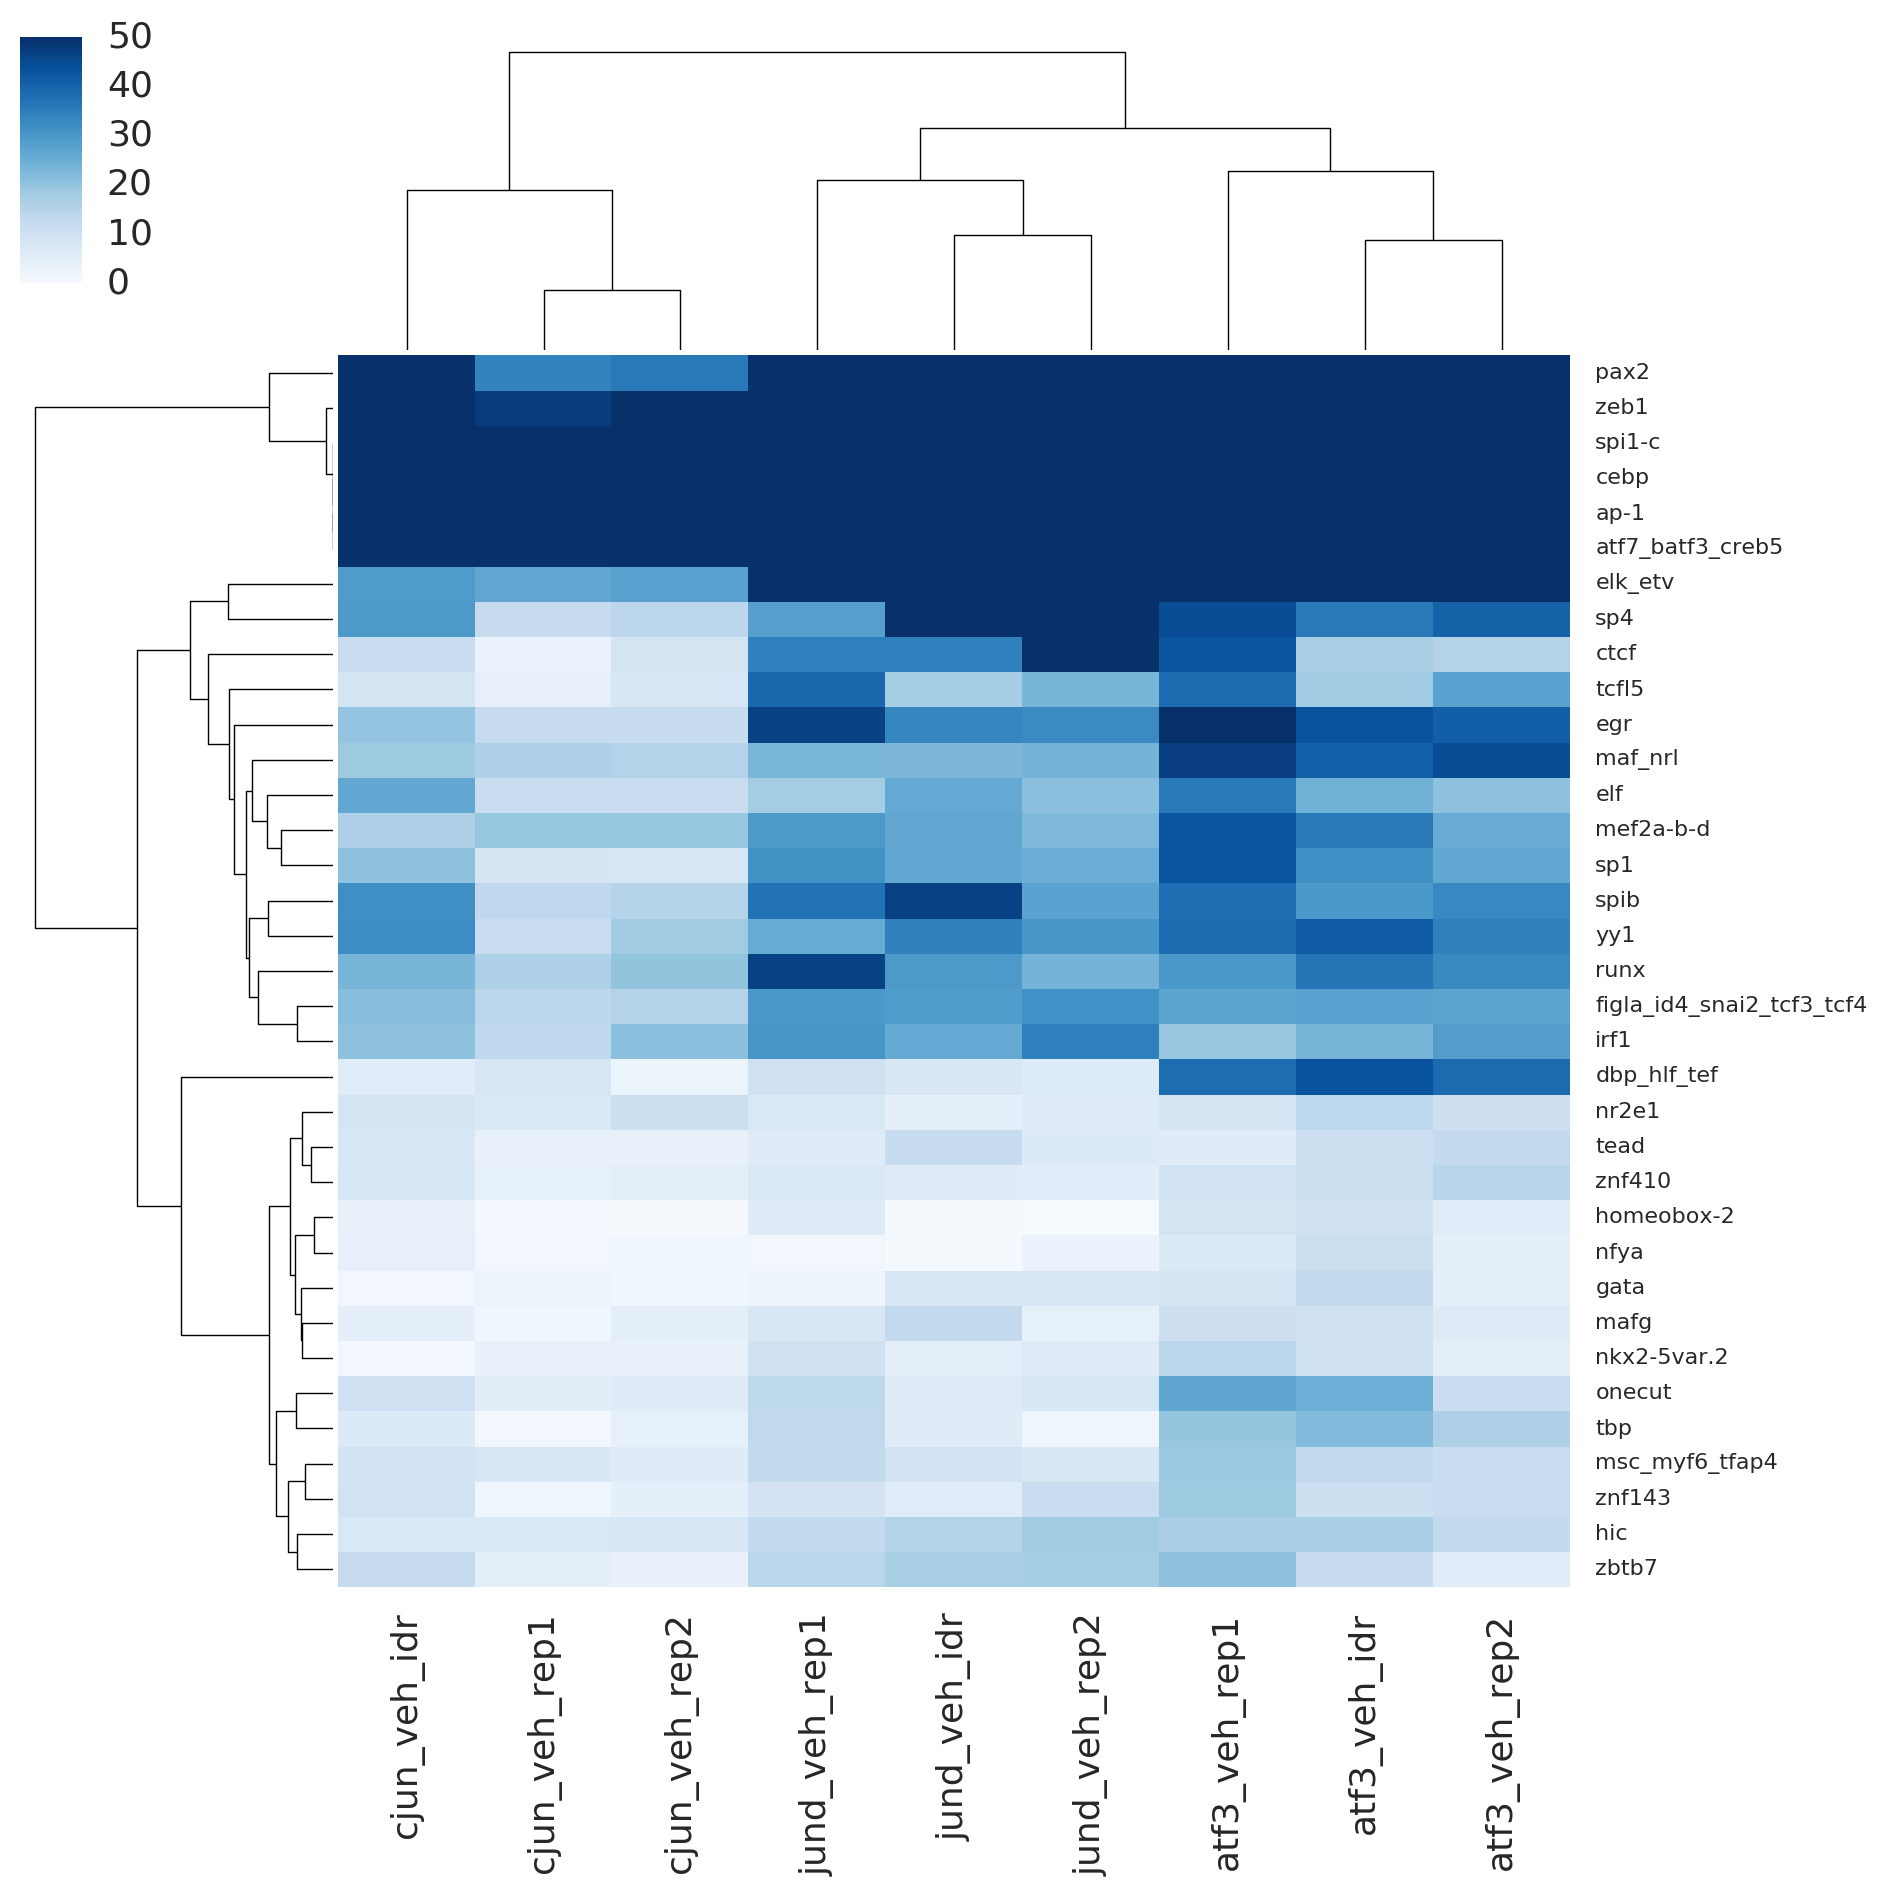

In [287]:
sns.set_style('darkgrid')
data = mean_pval_frame[[x for x in mean_pval_frame.columns if  'veh' in x]]+1e-50
data = data[data[[x for x in data.columns if 'idr' in x]].min(axis=1) < 1e-10]
cm = sns.clustermap(-np.log10(data),
#     yticklabels=False, 
#     row_cluster = False,
#     z_score = 0,
#     standard_scale = 0,
#     metric = 'correlation',
    vmin=0, 
    cmap ='Blues',
    
              )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=8, 
         rotation=0);

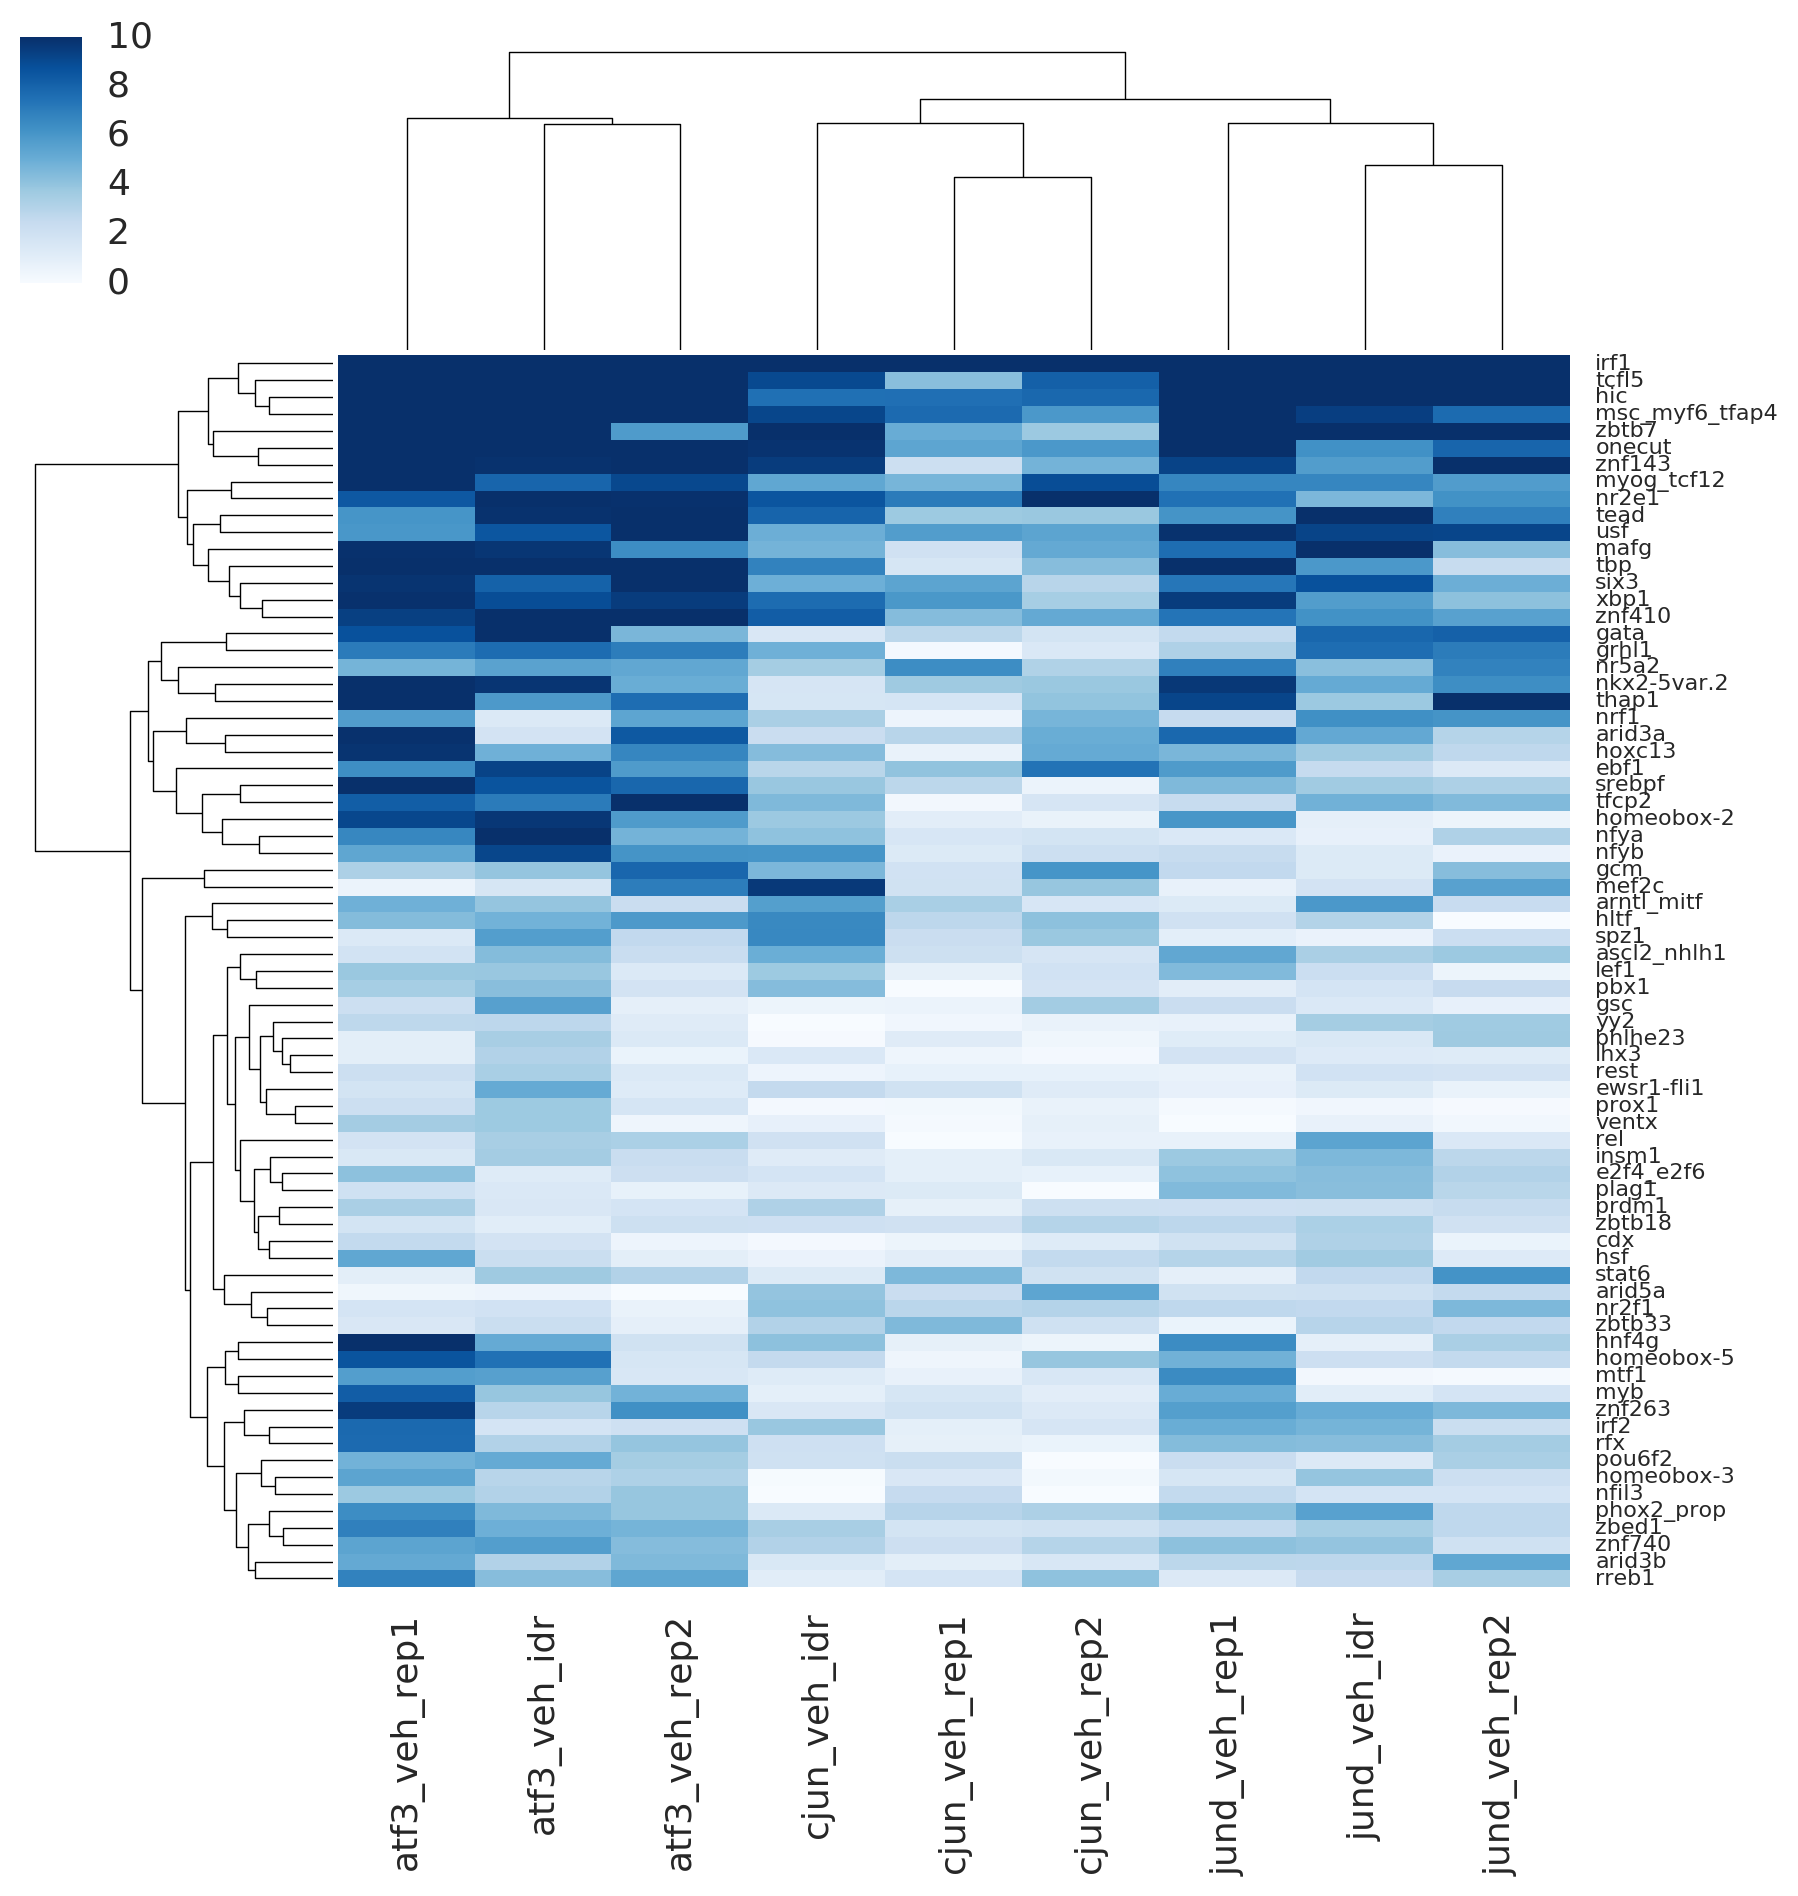

In [283]:
sns.set_style('darkgrid')
data = mean_pval_frame[[x for x in mean_pval_frame.columns if  'veh' in x]]+1e-10
data = data[(data[[x for x in data.columns if 'idr' in x]].min(axis=1) <1e-3) &
            (data[[x for x in data.columns if 'idr' in x]].min(axis=1) > 1e-10)
            ]
cm = sns.clustermap(-np.log10(data),
#     yticklabels=False, 
    vmin=0, 
    cmap ='Blues',
              )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=8, 
         rotation=0);

In [273]:
log_data = -np.log10(data)

In [198]:
log_data.isnull().sum()

atf3_veh_idr     0
atf3_veh_rep1    0
atf3_veh_rep2    0
cjun_veh_idr     0
cjun_veh_rep1    0
cjun_veh_rep2    0
jund_veh_idr     0
jund_veh_rep1    0
jund_veh_rep2    0
dtype: int64